In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import utils
import graphviz
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import ast
import load_data

FILE_NAME = "census_income"

In [2]:
X, y , sensitive = load_data.census()
print(utils.discrimination(y, sensitive))

0.19637403845538565


In [3]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

In [4]:


from tqdm.notebook import tqdm
from multiprocessing import Process, Pool
from functools import partial

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])

def xx(min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test, depth, k):

    clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=300)

    start = time.perf_counter()
    clf.fit(X_train, list(y_train))
    duration = time.perf_counter() - start
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
    discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
    discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
    discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)

    utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
    sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
    sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

    sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=False),8)
    sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=True),8)
    sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

    discri_test= list()
    utils.get_discri_test(clf.tree_, X_test, y_pred_test, sensitive_test, discri_test, X.columns, path=None)
    sum_discrimination_additive_test_pred = sum(discri_test)
    sum_discrimination_additive_test_pred_abs = 0
    [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
    #print(f"### Depth: {depth} state: {random_state} k:{k} ###")

    return [k, depth, random_state, clf.error_, clf.accuracy_, utils.perf_measure(y_train, y_pred_train, sensitive_train), accuracy_pred, accuracy_test, sum_misclassified_train,
            discrimination_train,       sum_discrimination_additive_train,      sum_discrimination_additive_train_abs,
            discrimination_train_pred,  sum_discrimination_additive_train_pred, sum_discrimination_additive_train_pred_abs,
            discrimination_test,        sum_discrimination_additive_test_pred,  sum_discrimination_additive_test_pred_abs,
            duration, min_supp, clf.tree_]

pool = Pool()
if False:
    #result = pd.read_csv('save/'+FILE_NAME+".csv")
    min_supp = 2
    args = []
    for depth in [1, 2, 3, 4, 5 , 6 , 7]:
        for k in [0, 1000, 2000, 3000, 4000, 5000, 10000, 100000]:
            args.append((depth, k))
    for random_state in tqdm(range(2, 102, 5)):
        if random_state in [27,67]:
                continue
        result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])
        X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
        
        
        for res in pool.starmap(partial(xx, min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test), tqdm(args)):
            result.loc[len(result.index)] = res

        
        

        #result = result.sort_values(['k', 'depth', 'min_supp'])
        result.to_csv('save/'+FILE_NAME+"_"+str(random_state)+'.csv', index=False)

In [5]:

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])  
for random_state in tqdm(range(2, 102, 5)):
    if random_state in [27,67]:
        continue
    result = pd.concat([result, pd.read_csv('save/'+FILE_NAME+"_"+str(random_state)+'.csv')])
   
result.to_csv('save/'+FILE_NAME+'.csv', index=False)
result

  0%|          | 0/20 [00:00<?, ?it/s]

,k,depth,random_state,clf.error_,clf.accuracy_,confusion,accuracy_pred,accuracy_test,sum_misclassified_train,discrimination_train,...,sum_discrimination_additive_train_abs,discrimination_train_pred,sum_discrimination_additive_train_pred,sum_discrimination_additive_train_pred_abs,discrimination_test,sum_discrimination_additive_test_pred,sum_discrimination_additive_test_pred_abs,duration,min_supp,clf.tree_
0,0,1,2,2856.0,0.762948,"((140, 32, 2386, 5580), (15, 11, 427, 3457))",0.762948,0.762616,2856,0.197352,...,0.197352,0.014486,0.014486,0.014486,0.005957,0.005957,0.005957,0.287001,2,"{'feat': 19, 'left': {'value': 1, 'error': 43...."
1,1000,1,2,2870.48584,0.761746,"((140, 32, 2386, 5580), (15, 11, 427, 3457))",0.762948,0.762616,2856,0.197352,...,0.197352,0.014486,0.014486,0.014486,0.005957,0.005957,0.005957,0.314848,2,"{'feat': 19, 'left': {'value': 1, 'error': 57...."
2,2000,1,2,2884.97168,0.760544,"((140, 32, 2386, 5580), (15, 11, 427, 3457))",0.762948,0.762616,2856,0.197352,...,0.197352,0.014486,0.014486,0.014486,0.005957,0.005957,0.005957,0.294506,2,"{'feat': 19, 'left': {'value': 1, 'error': 71...."
3,3000,1,2,2899.457275,0.759341,"((140, 32, 2386, 5580), (15, 11, 427, 3457))",0.762948,0.762616,2856,0.197352,...,0.197352,0.014486,0.014486,0.014486,0.005957,0.005957,0.005957,0.269003,2,"{'feat': 19, 'left': {'value': 1, 'error': 86...."
4,4000,1,2,2913.943115,0.758139,"((140, 32, 2386, 5580), (15, 11, 427, 3457))",0.762948,0.762616,2856,0.197352,...,0.197352,0.014486,0.014486,0.014486,0.005957,0.005957,0.005957,0.276991,2,"{'feat': 19, 'left': {'value': 1, 'error': 100..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,3000,7,97,2874.406006,0.76142,"((301, 171, 2194, 5446), (84, 144, 365, 3343))",0.761454,0.74668,2874,0.193494,...,0.193494,0.000259,0.000259,0.000259,-0.008094,-0.008094,0.008094,300.666953,2,"{'feat': 17, 'left': {'value': 1, 'error': 315..."
52,4000,7,97,2874.54126,0.761409,"((301, 171, 2194, 5446), (84, 144, 365, 3343))",0.761454,0.74668,2874,0.193494,...,0.193494,0.000259,0.000259,0.000259,-0.008094,-0.008094,0.008094,300.878965,2,"{'feat': 17, 'left': {'value': 1, 'error': 315..."
53,5000,7,97,2874.676514,0.761398,"((301, 171, 2194, 5446), (84, 144, 365, 3343))",0.761454,0.74668,2874,0.193494,...,0.193494,0.000259,0.000259,0.000259,-0.008094,-0.008094,0.008094,300.741044,2,"{'feat': 17, 'left': {'value': 1, 'error': 315..."
54,10000,7,97,2875.353027,0.761342,"((301, 171, 2194, 5446), (84, 144, 365, 3343))",0.761454,0.74668,2874,0.193494,...,0.193494,0.000259,0.000259,0.000259,-0.008094,-0.008094,0.008094,301.065298,2,"{'feat': 17, 'left': {'value': 1, 'error': 316..."


accuracy_pred = 0.80926295
accuracy_test = 0.82204515
discrimination_train = 0.19722738
discrimination_train_pred = 0.12655229


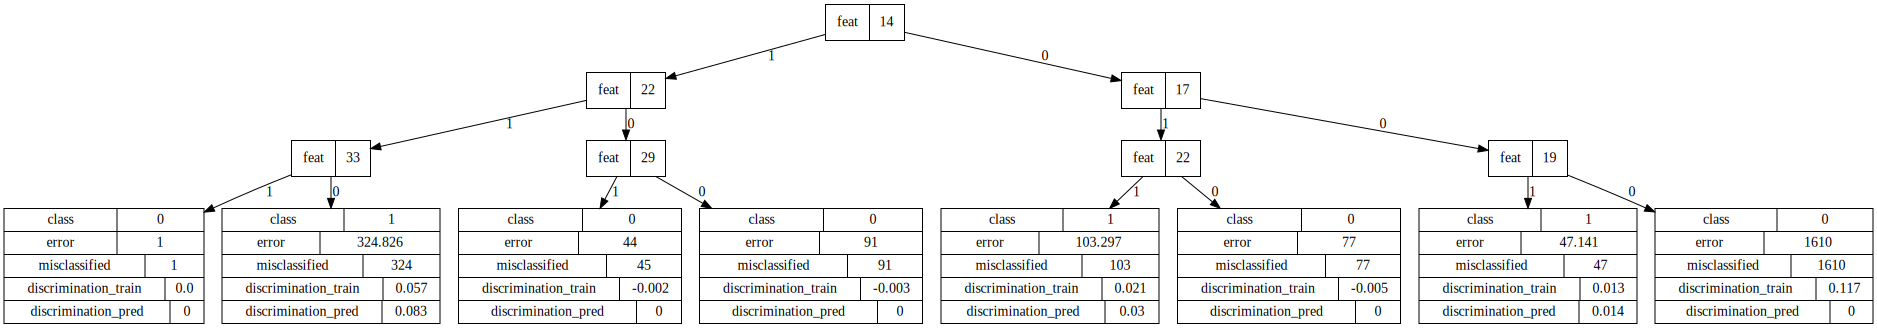

In [6]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=1, time_limit=300)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)


In [7]:
discri_test= list()
utils.get_discri_test(clf.tree_, X_test, y_test, sensitive_test, discri_test, X.columns, path=None)
sum_discrimination_additive_test_pred = sum(discri_test)
sum_discrimination_additive_test_pred_abs = 0
[sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
print(sum_discrimination_additive_test_pred)
sum_discrimination_additive_test_pred_abs

0.19311822800063677


0.22099110735854494

In [8]:
discri_test

[0.0009813542688910696,
 0.05708378589147069,
 -9.067955256693684e-05,
 -0.007413557197639108,
 0.023635121601279993,
 -0.006432202928748038,
 0.010168200494505826,
 0.11518620542344327]

In [9]:
utils.discrimination(y_train, sensitive_train)

0.19722738089569225

In [10]:
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train', do_abs=True))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred', do_abs=True))

0.19722738089569222
0.2193770388735279
0.1265522864076726
0.1265522864076726


In [11]:
utils.sum_elem_tree(clf.tree_, 'misclassified')

2298

In [12]:
print(utils.discrimination(y_train, sensitive_train))
print(utils.discrimination(y_pred_train, sensitive_train))
print(utils.discrimination(y_test, sensitive_test))
print(utils.discrimination(y_pred_test, sensitive_test))

0.19722738089569225
0.1265522864076726
0.19311822800063677
0.12116501058935664


In [13]:
clf.tree_

{'feat': 14,
 'left': {'feat': 22,
  'left': {'feat': 33,
   'left': {'value': 0,
    'error': 1.0,
    'transactions': [6208,
     4131,
     5507,
     7075,
     4358,
     10564,
     3081,
     396,
     5109,
     9463,
     8856,
     5339],
    'proba': [0.9166666666666666, 0.08333333333333333],
    'discrimination_additive_train': 0.00012331976815883587,
    'discrimination_additive_pred': 0.0,
    'misclassified': 1},
   'right': {'value': 1,
    'error': 324.826202,
    'transactions': [8196,
     8197,
     10244,
     7,
     10247,
     2060,
     13,
     6156,
     15,
     10254,
     10255,
     8212,
     8215,
     8216,
     2074,
     10268,
     2078,
     2080,
     8227,
     4135,
     10283,
     8236,
     8239,
     2096,
     10288,
     4147,
     8243,
     8245,
     6199,
     8254,
     6207,
     10304,
     10307,
     2120,
     6221,
     6222,
     8269,
     2128,
     10318,
     10320,
     10323,
     6228,
     4183,
     6231,
     2139,
  

# Graphs

<Figure size 648x432 with 0 Axes>

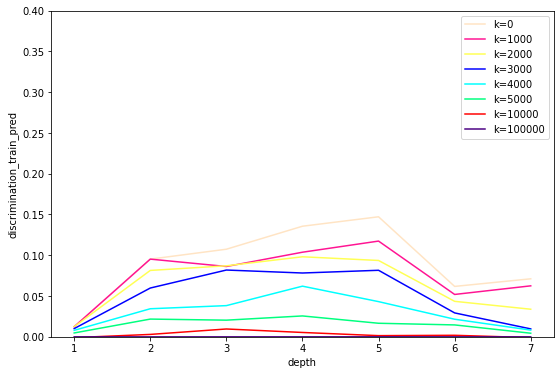

In [14]:
utils.plot_mean("depth", "discrimination_train_pred", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

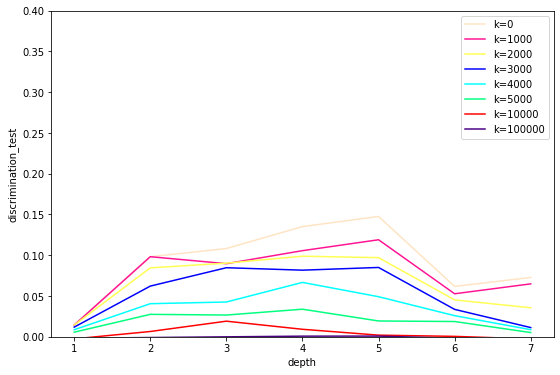

In [15]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

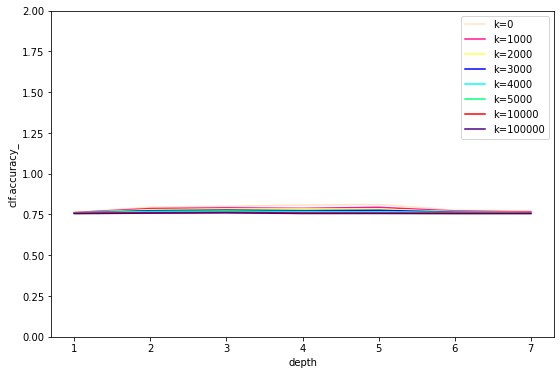

In [16]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

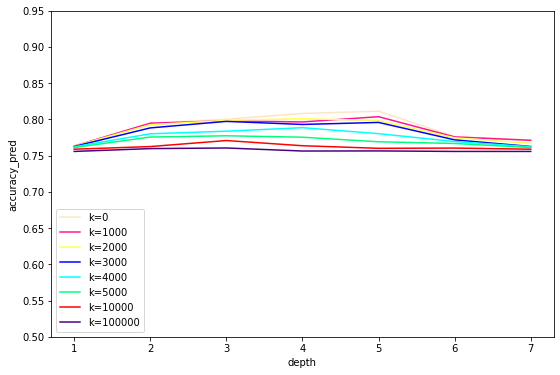

In [17]:
utils.plot_mean("depth", "accuracy_pred", result, 0.5, 0.95)

<Figure size 648x432 with 0 Axes>

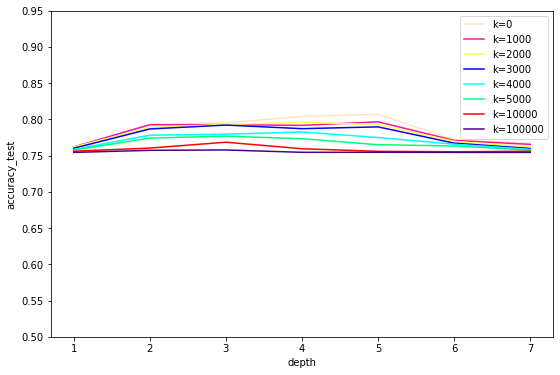

In [18]:
utils.plot_mean("depth", "accuracy_test", result, 0.5, 0.95)

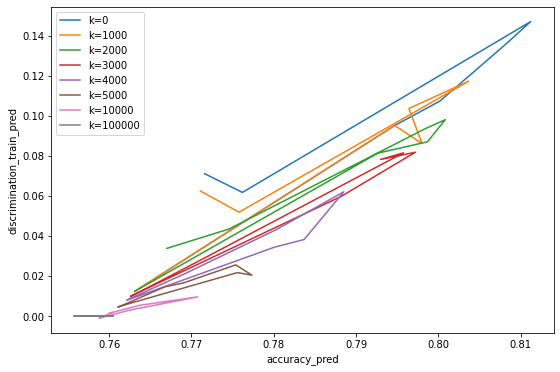

In [19]:
utils.plot2("accuracy_pred", "discrimination_train_pred", result)

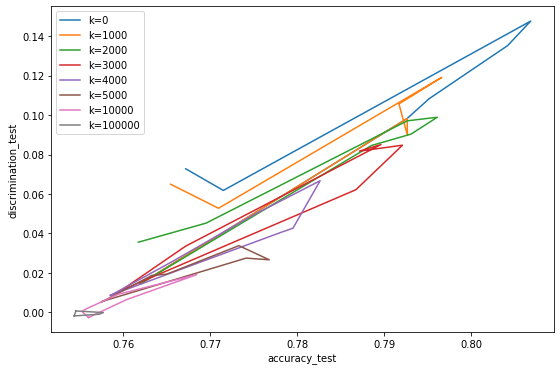

In [20]:
utils.plot2("accuracy_test", "discrimination_test", result)

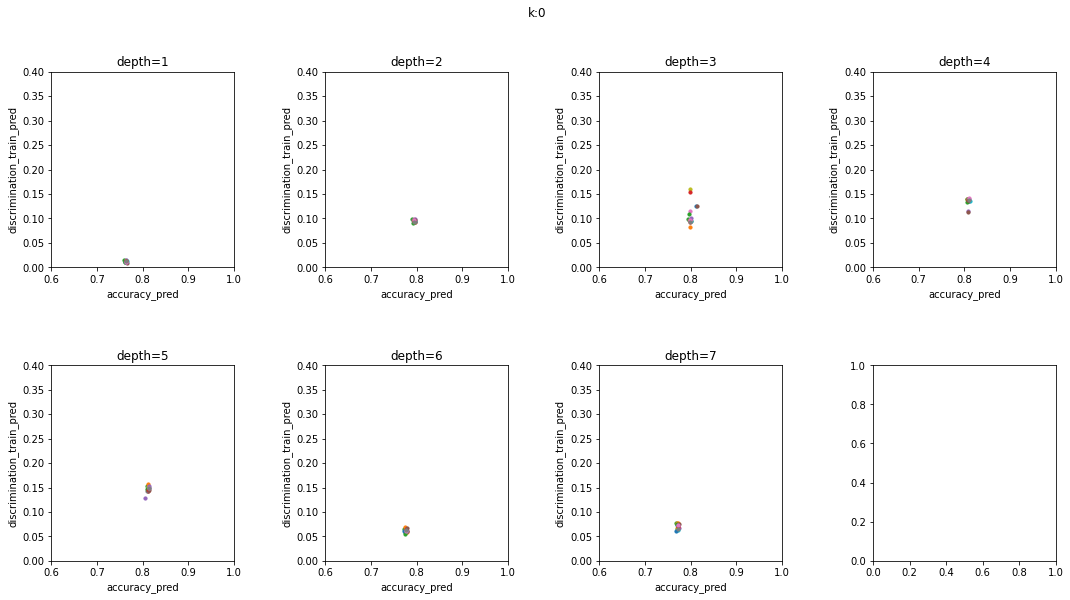

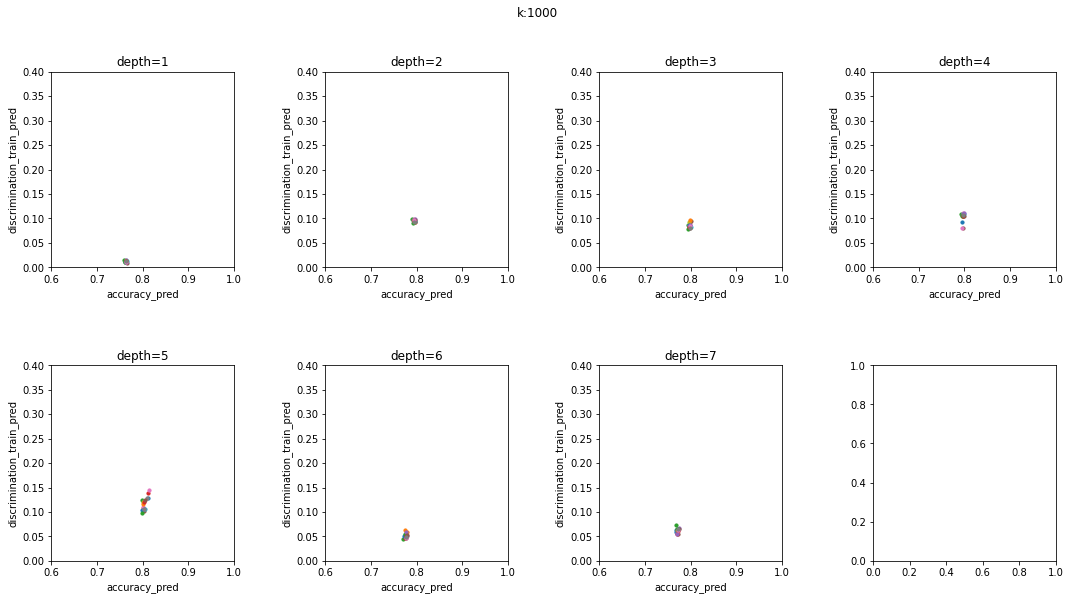

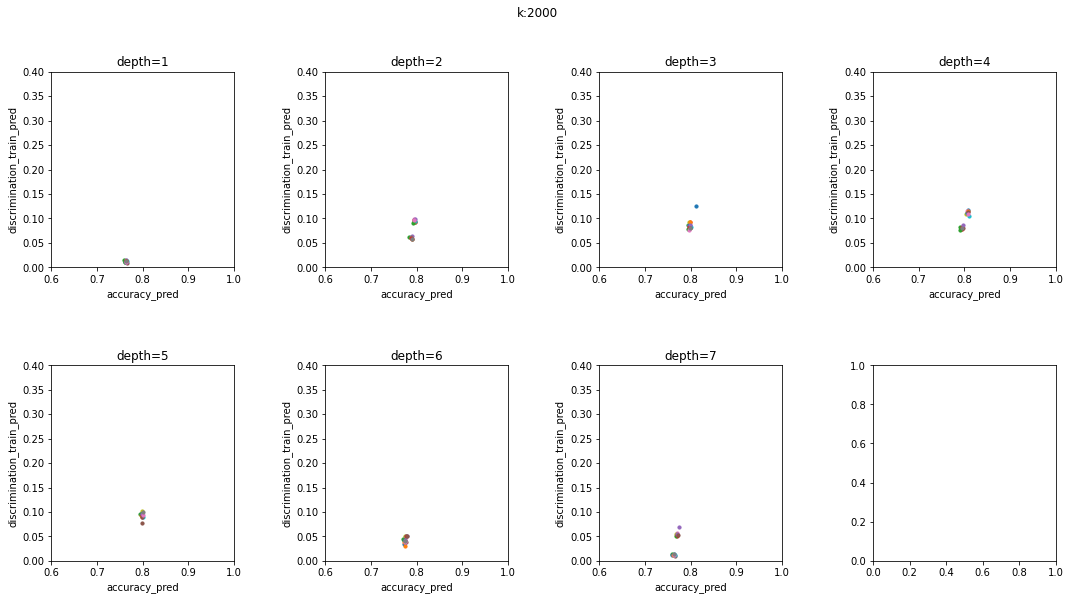

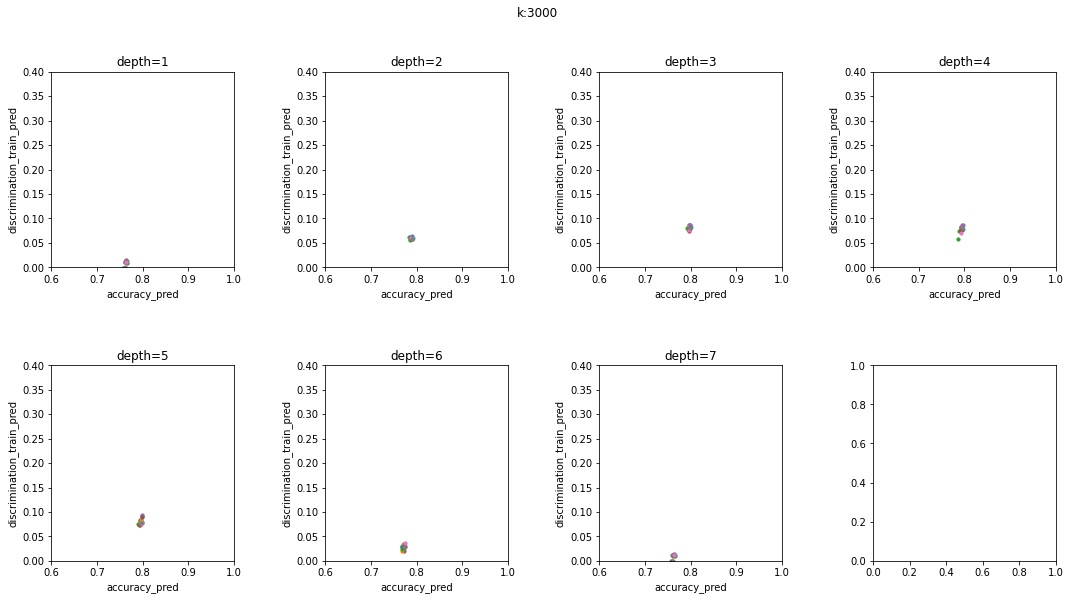

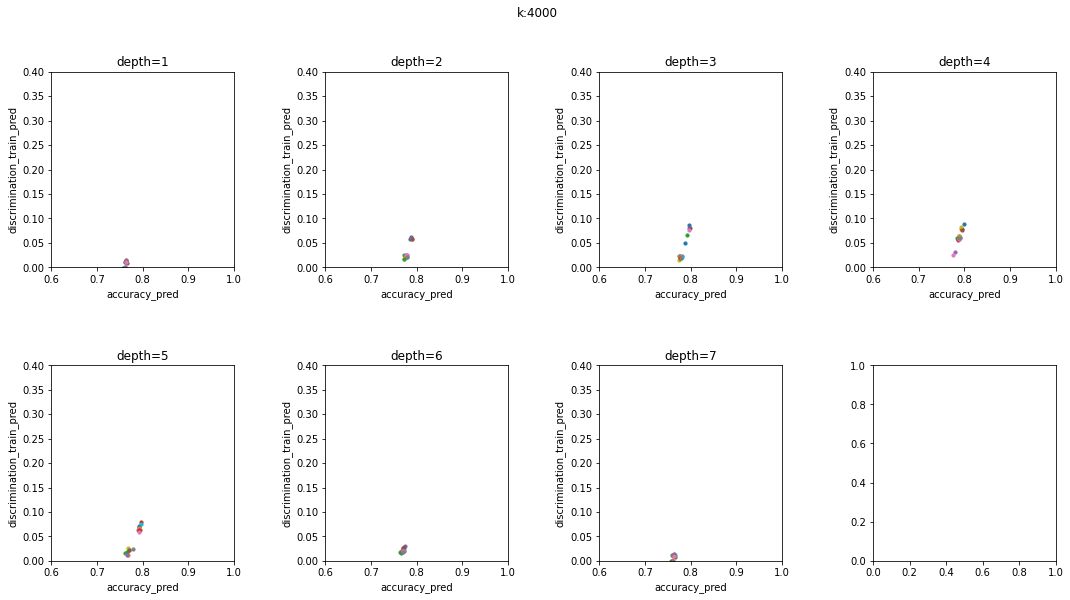

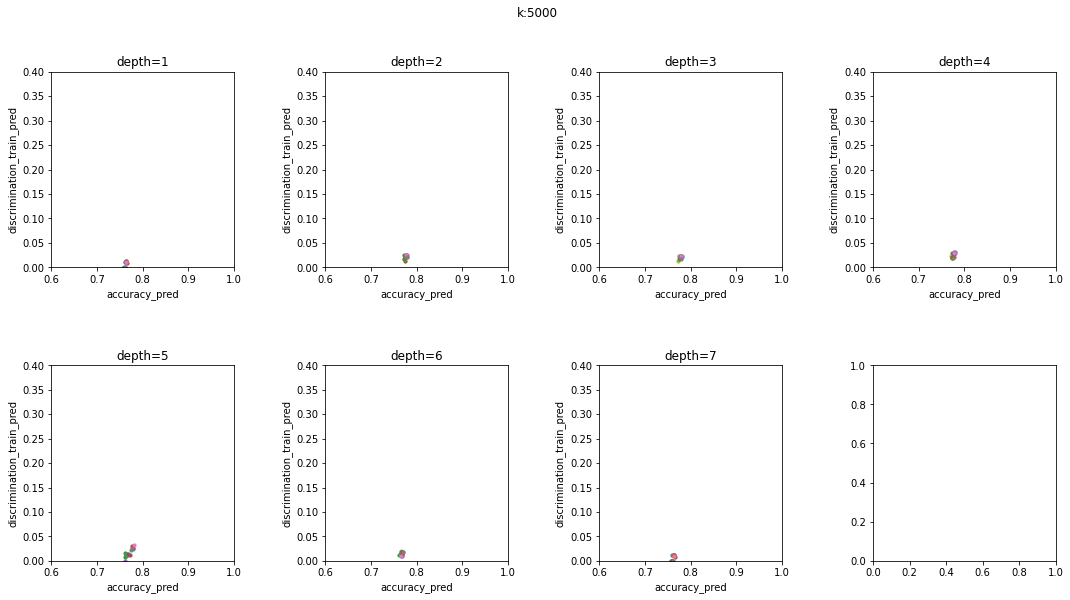

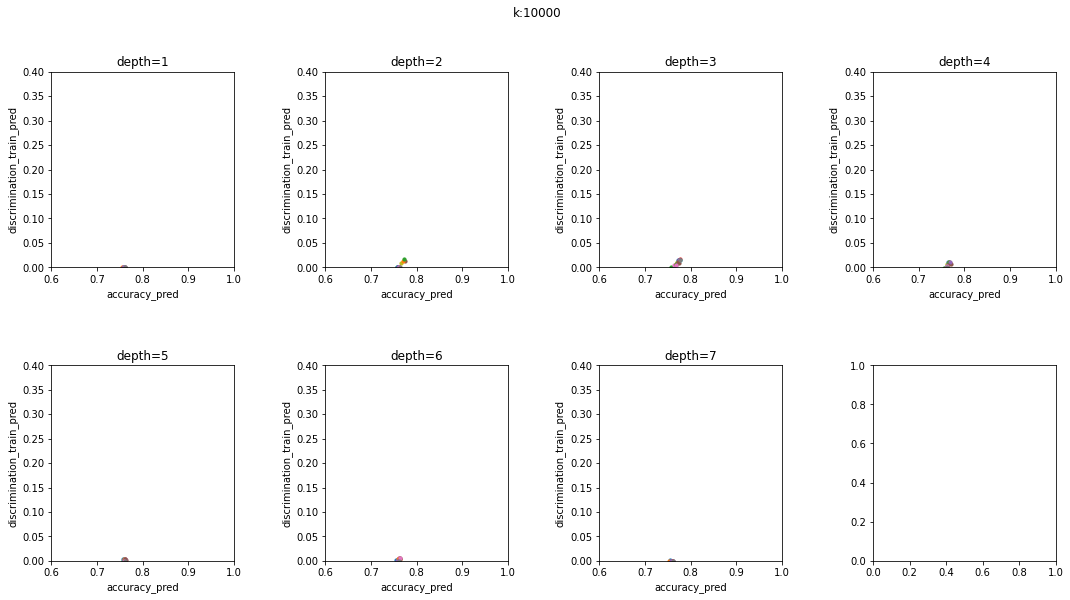

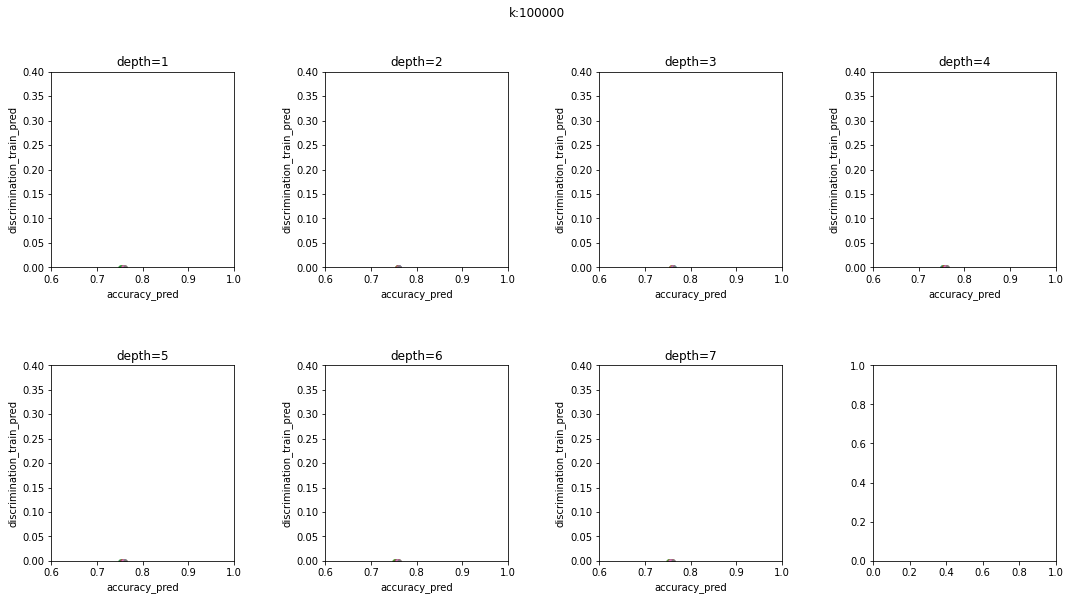

In [21]:
utils.plot_one_scatter_by_depth("accuracy_pred", "discrimination_train_pred", result, (0.6, 1), (0, 0.4))

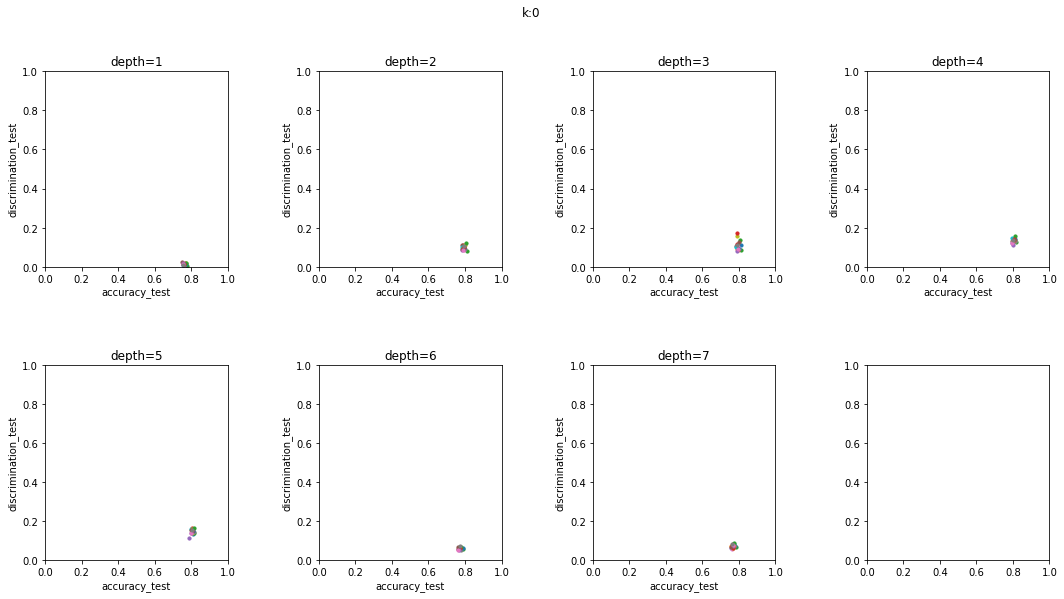

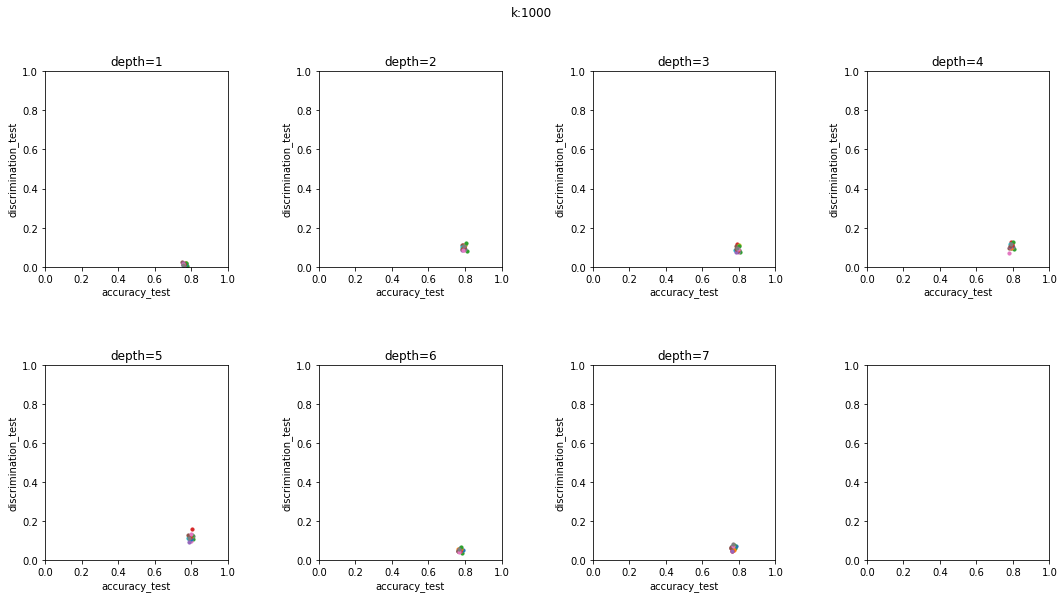

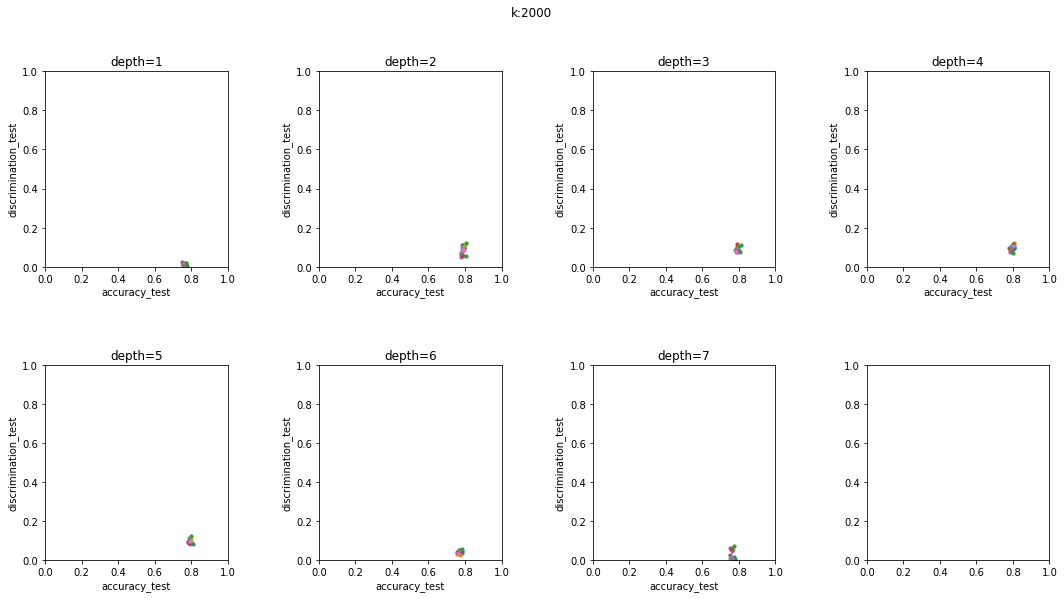

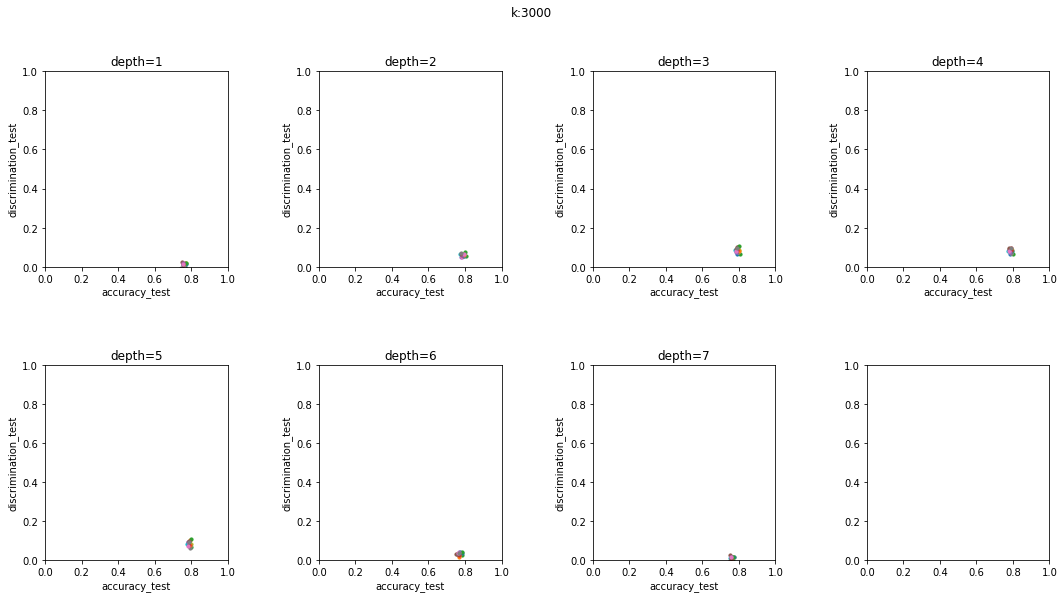

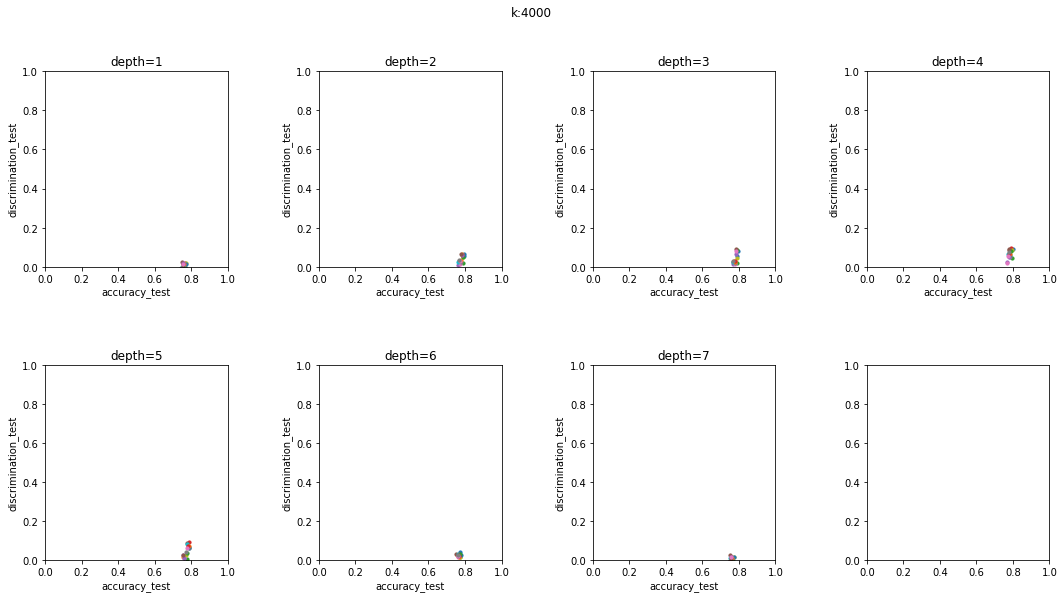

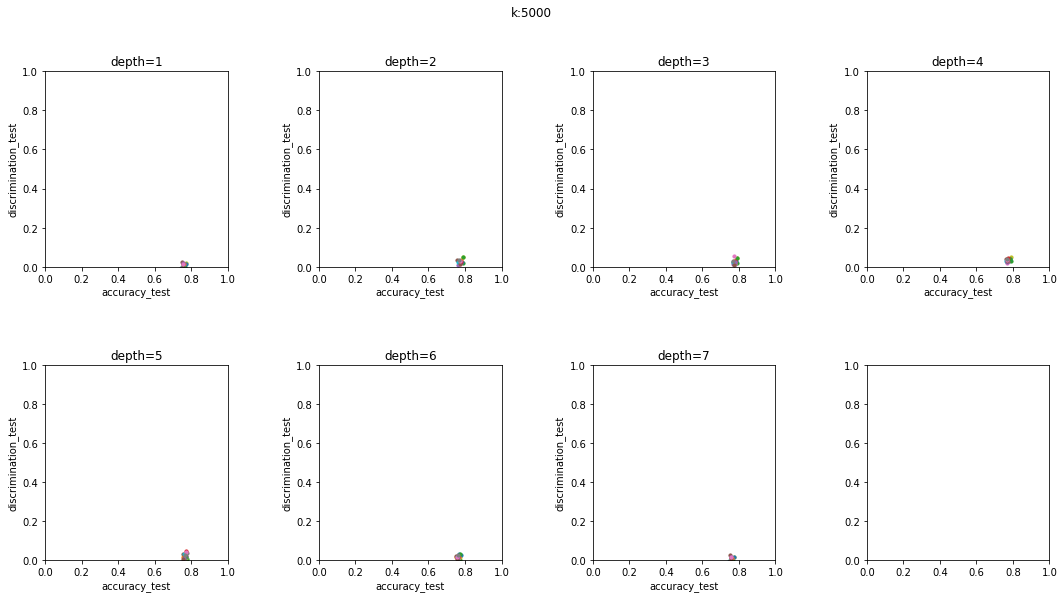

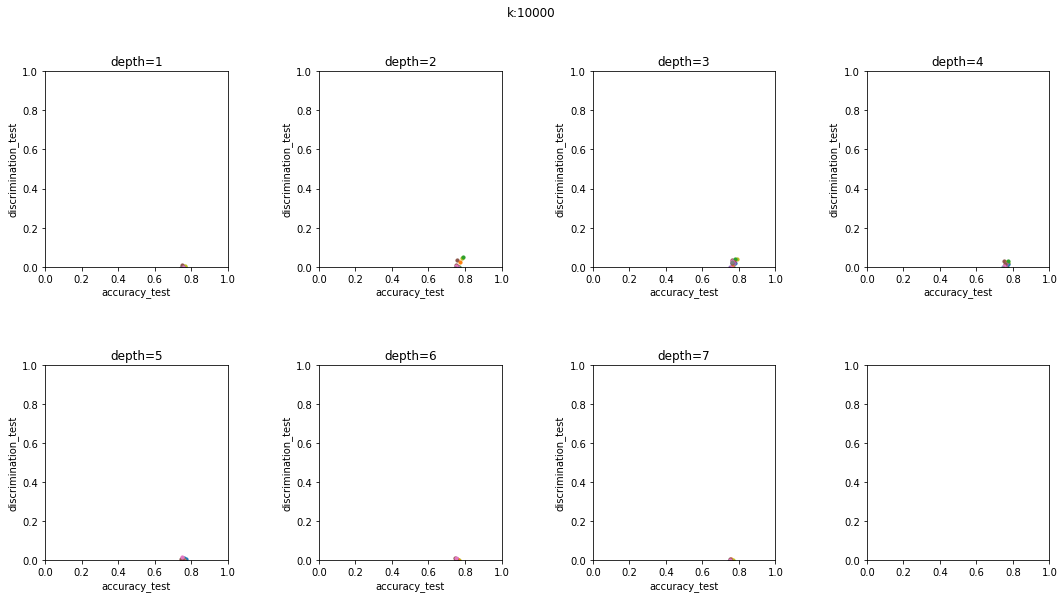

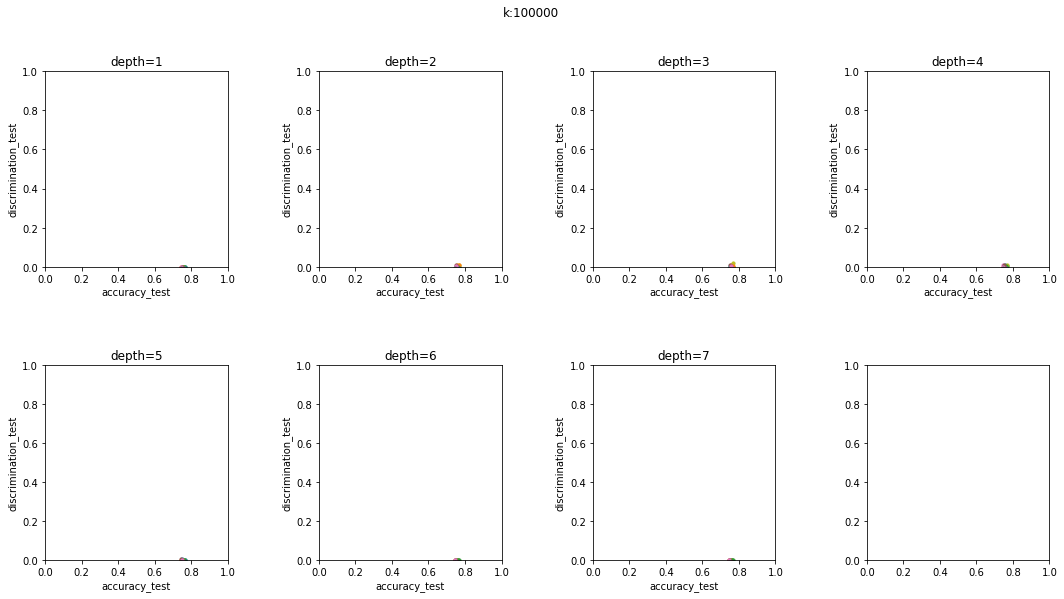

In [22]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

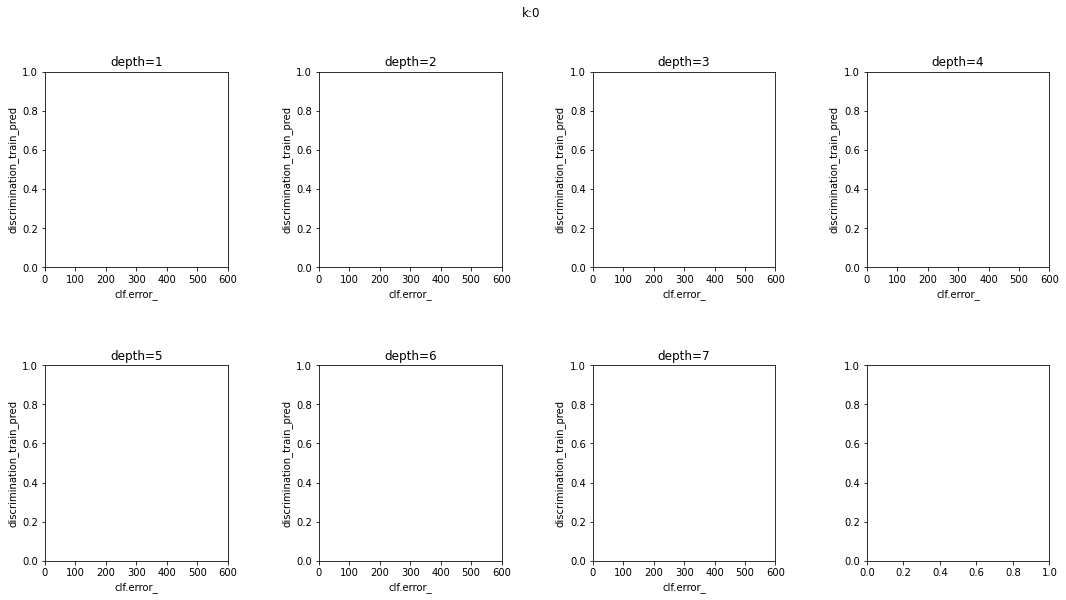

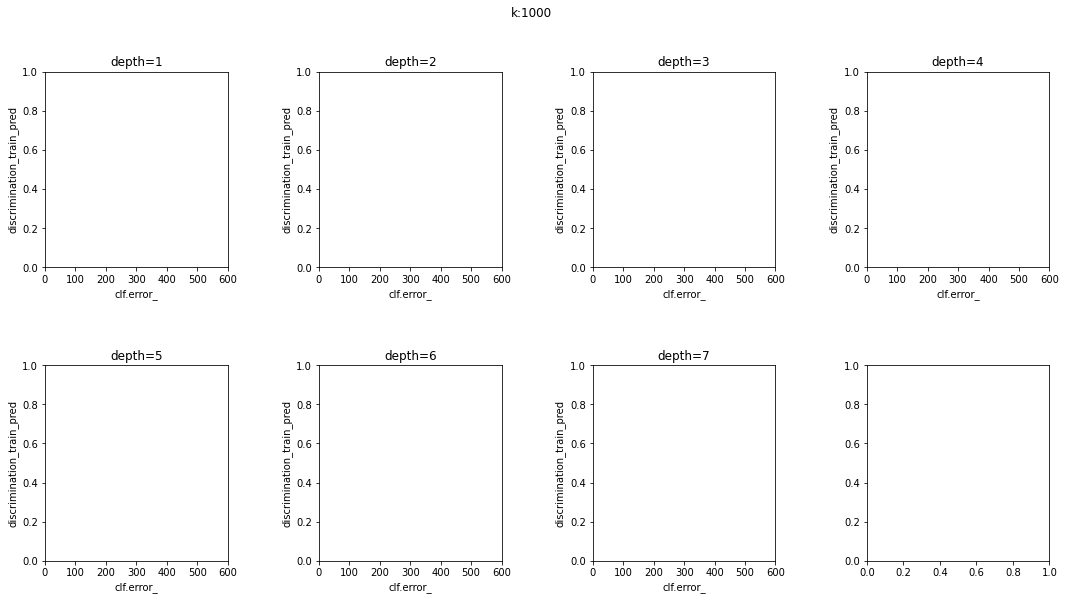

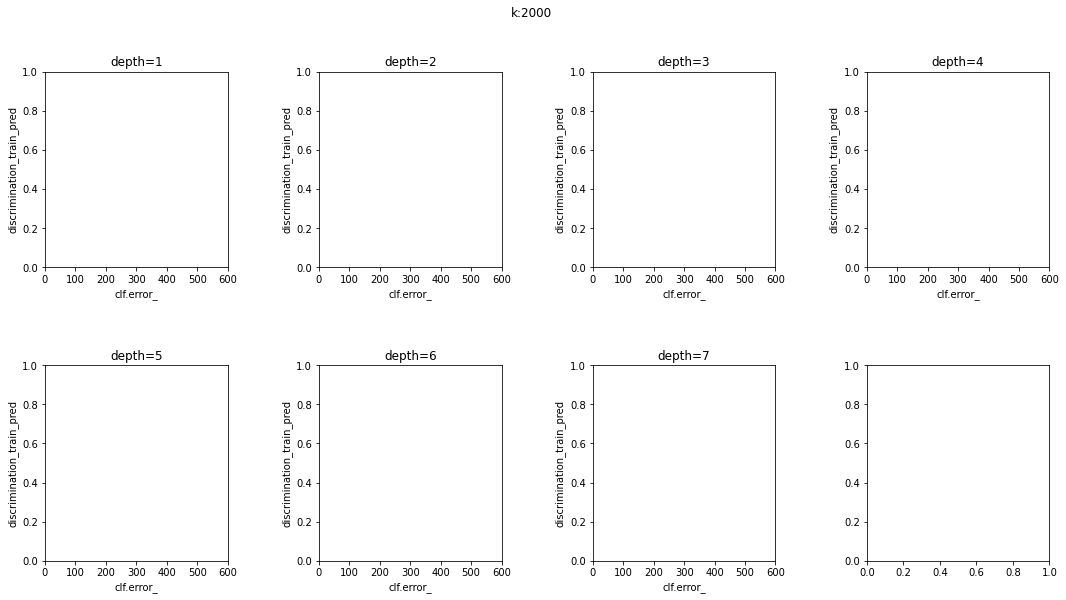

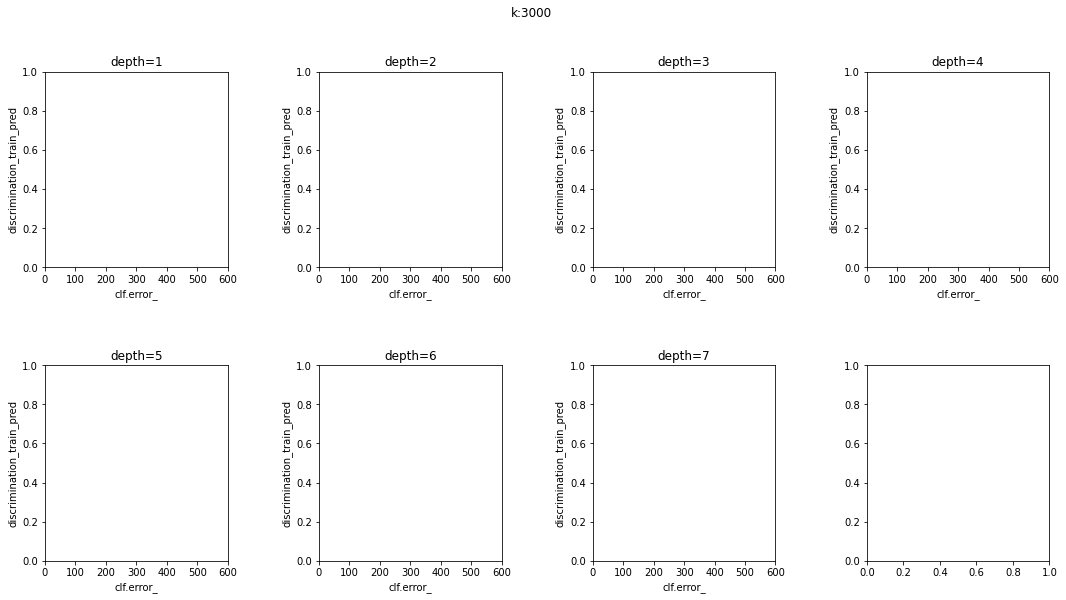

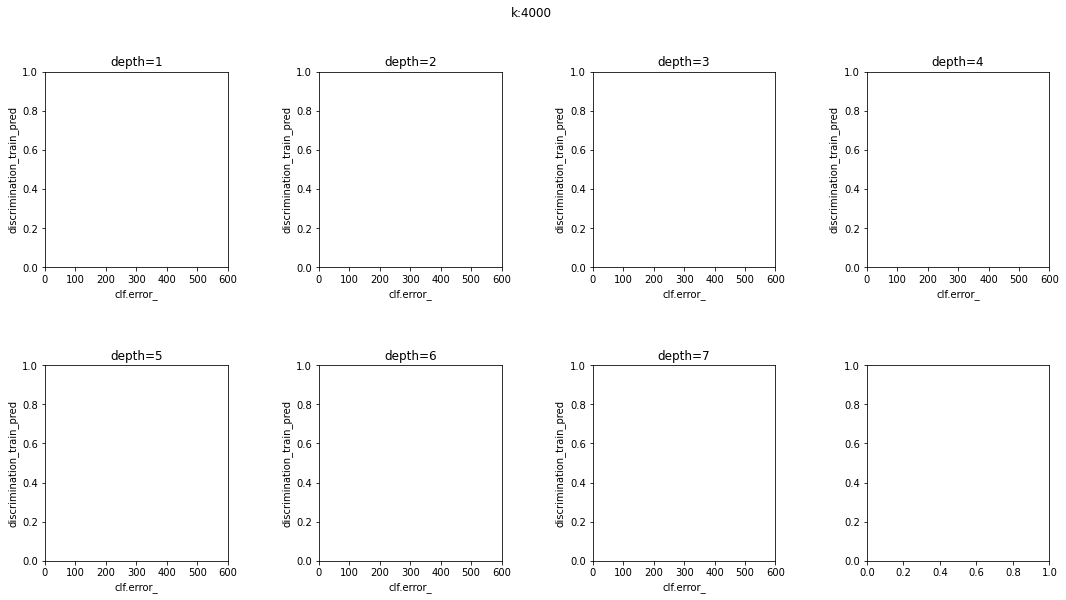

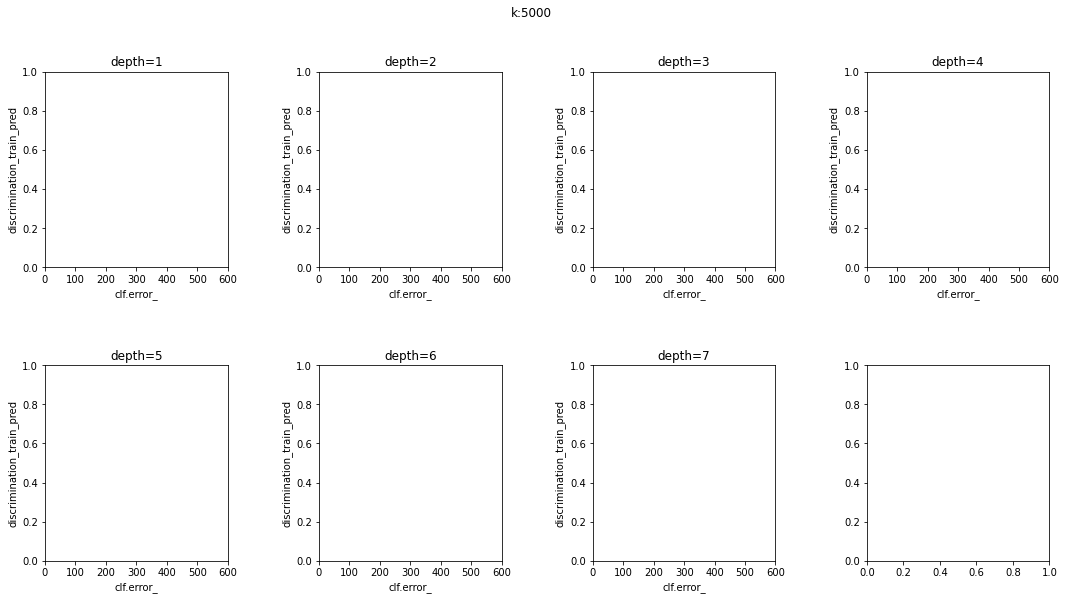

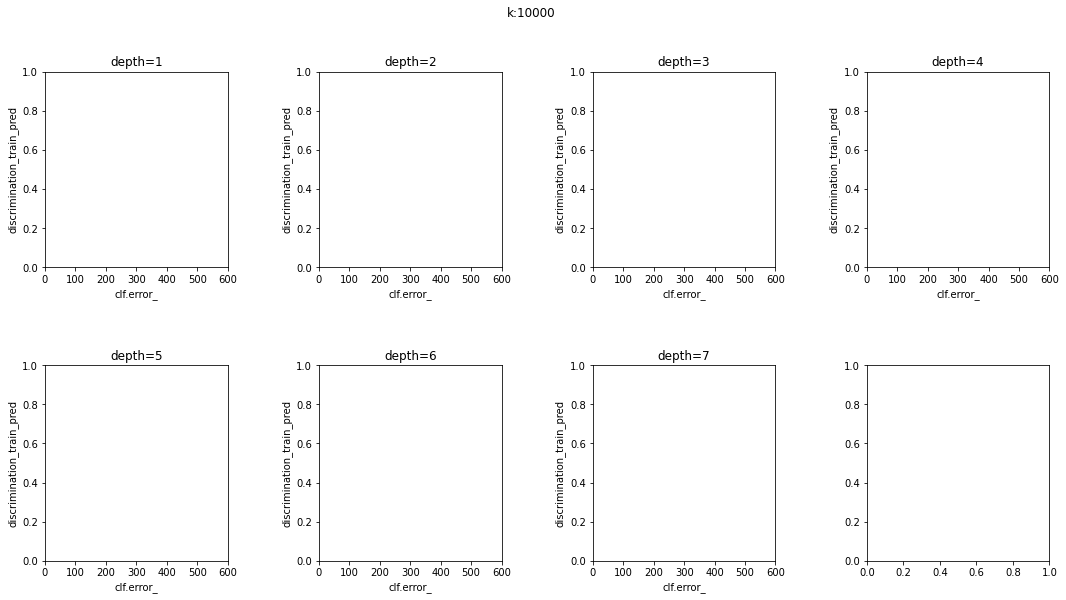

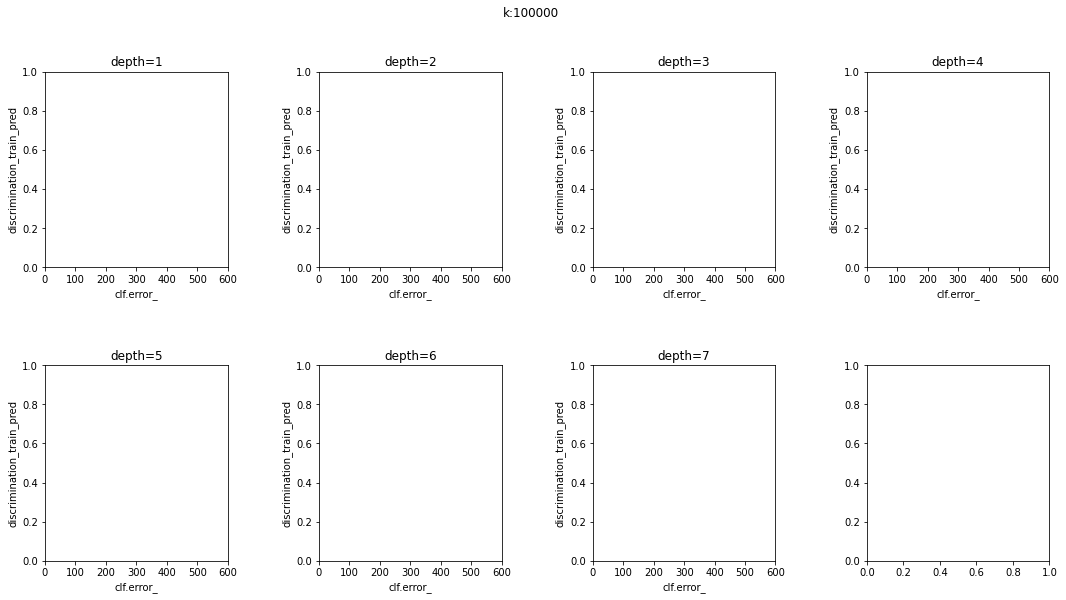

In [23]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train_pred", result, (0, 600), (0, 1))

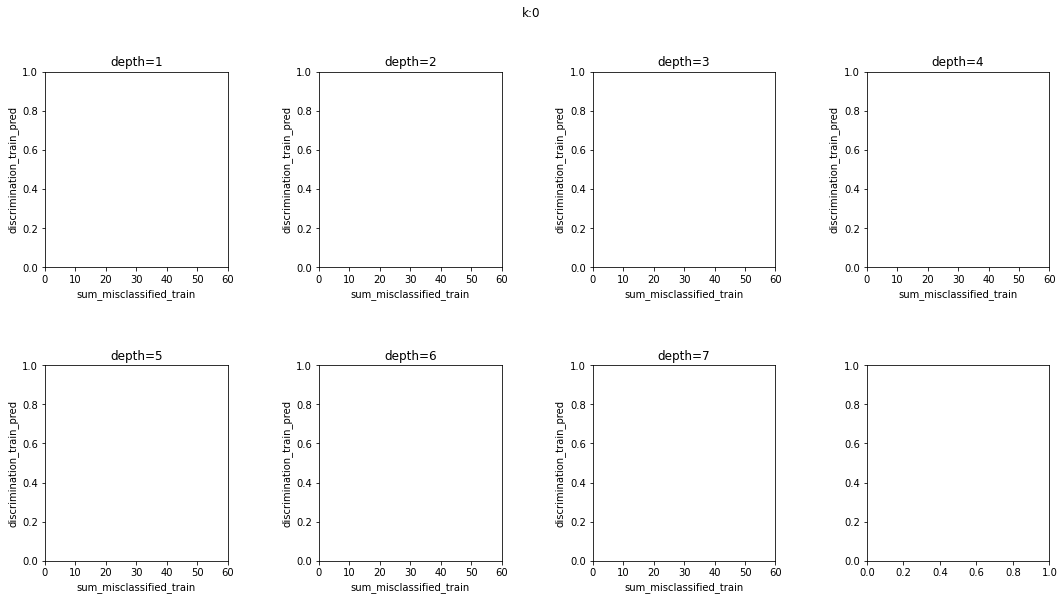

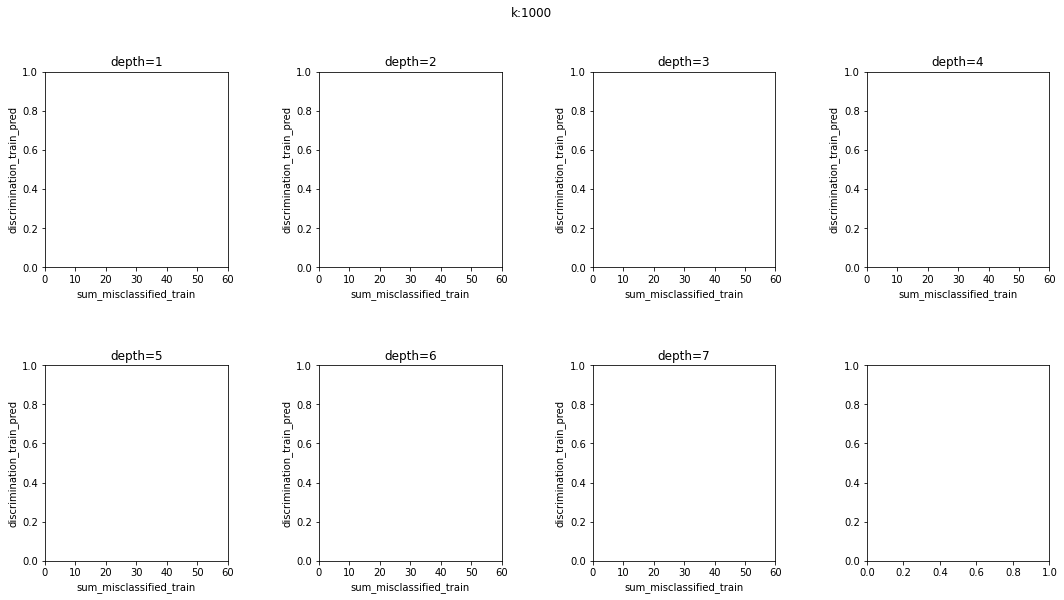

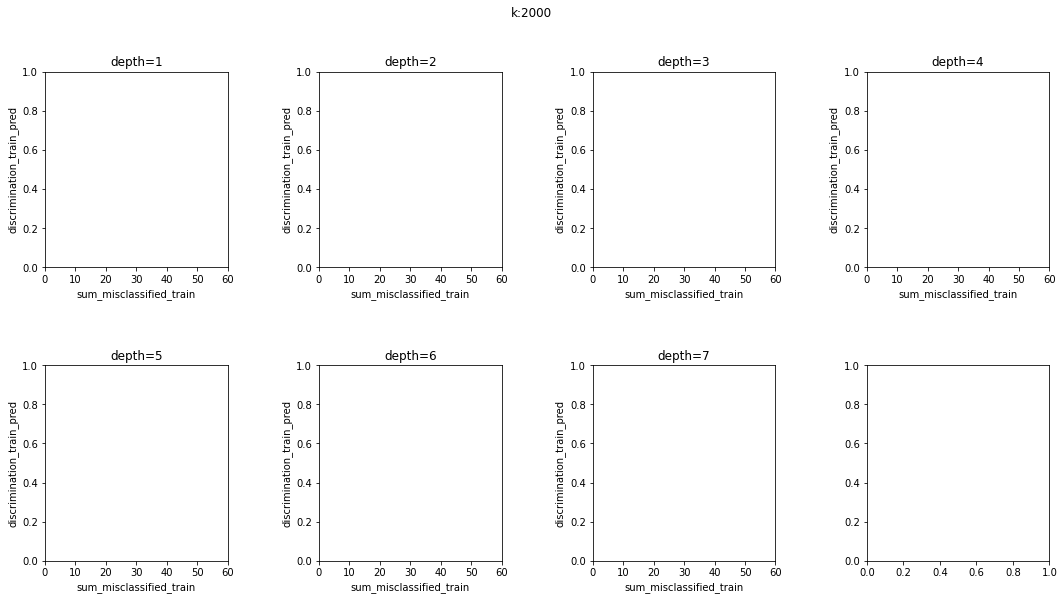

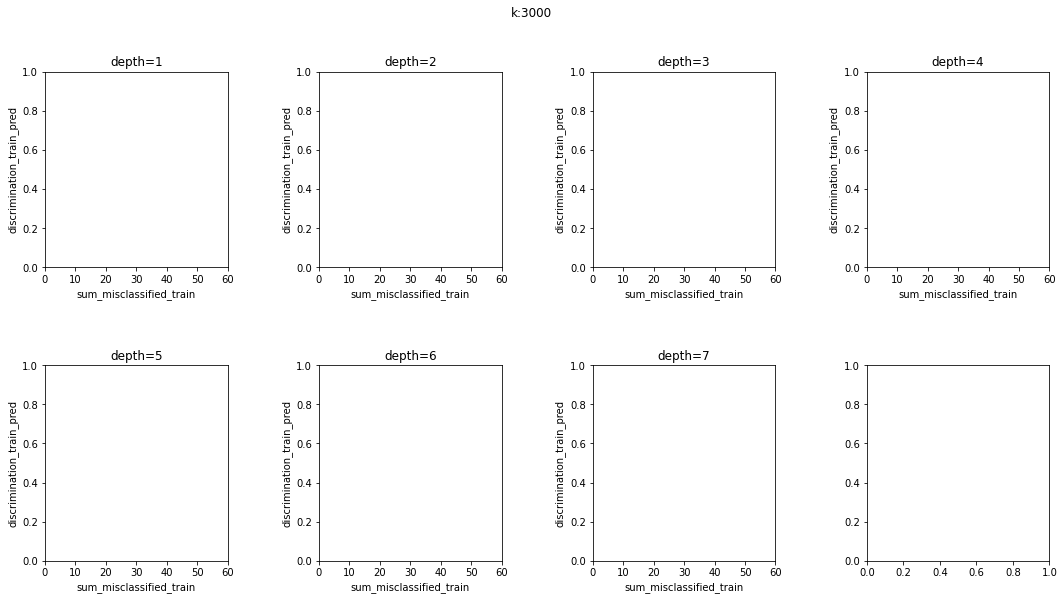

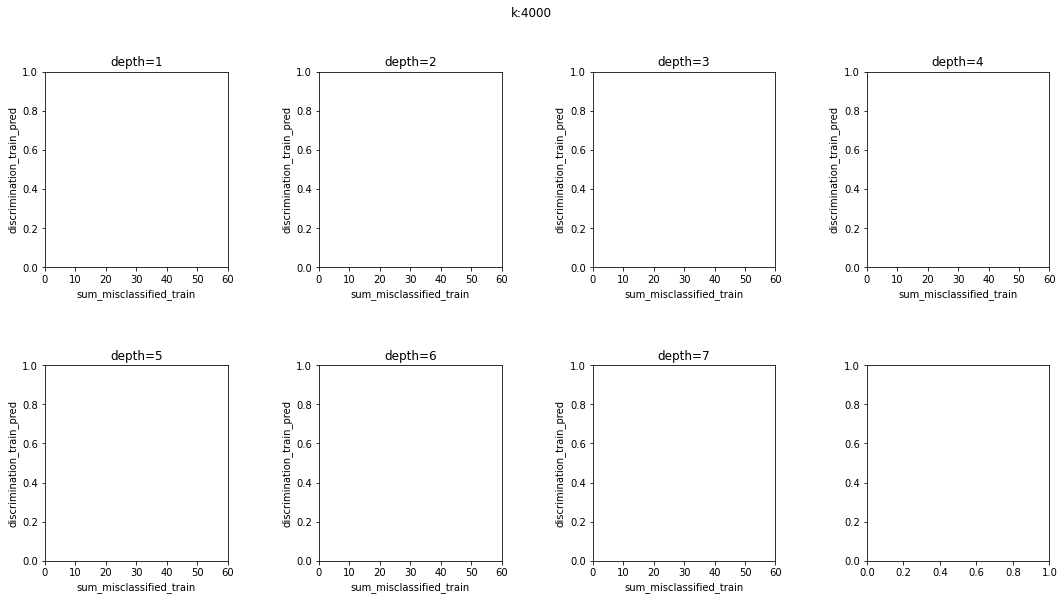

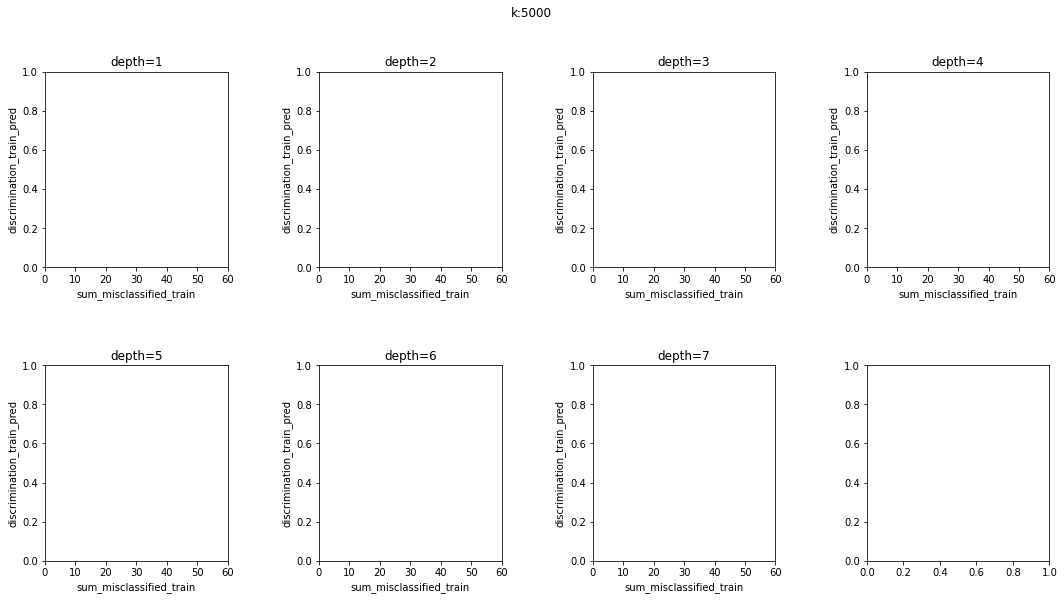

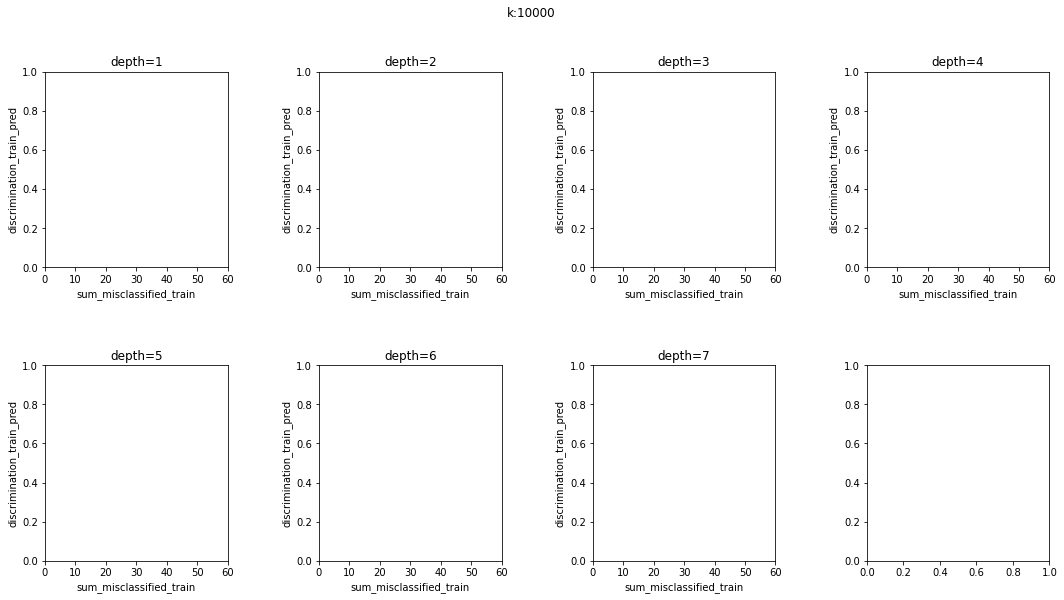

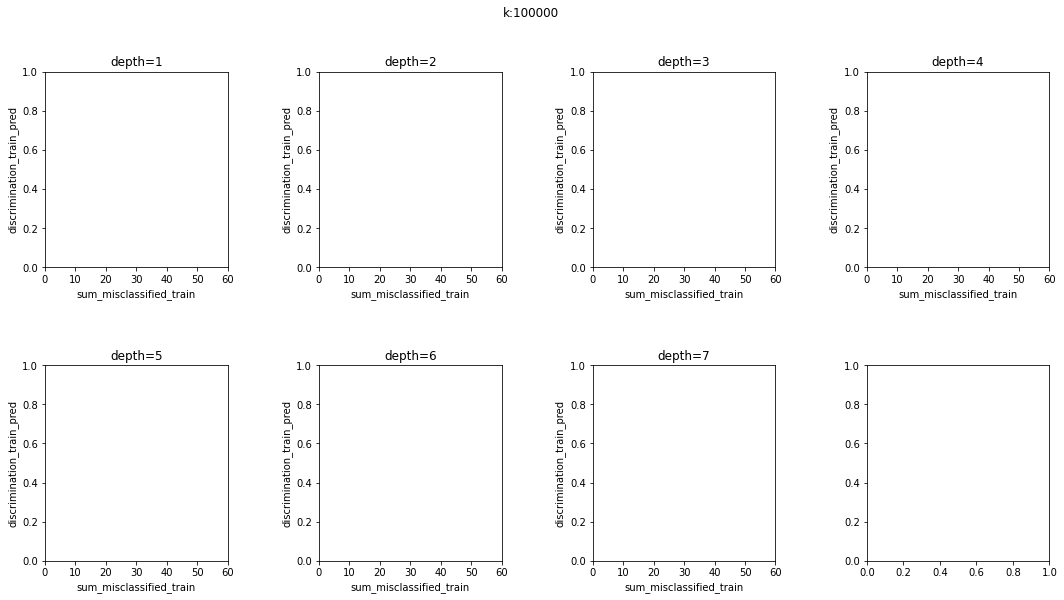

In [24]:
utils.plot_one_scatter_by_depth("sum_misclassified_train", "discrimination_train_pred", result, (0, 60), (0, 1))

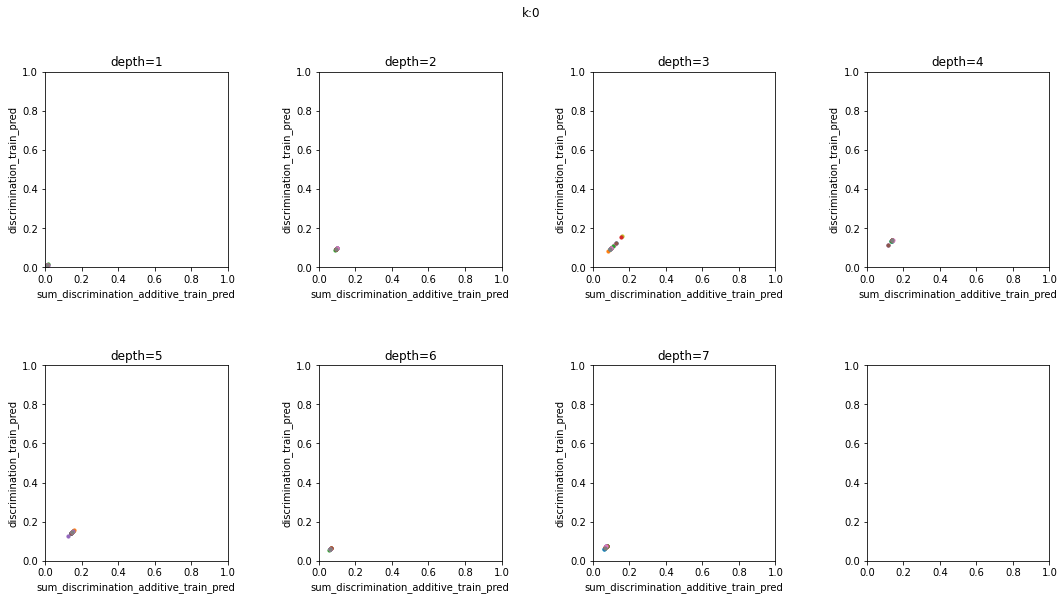

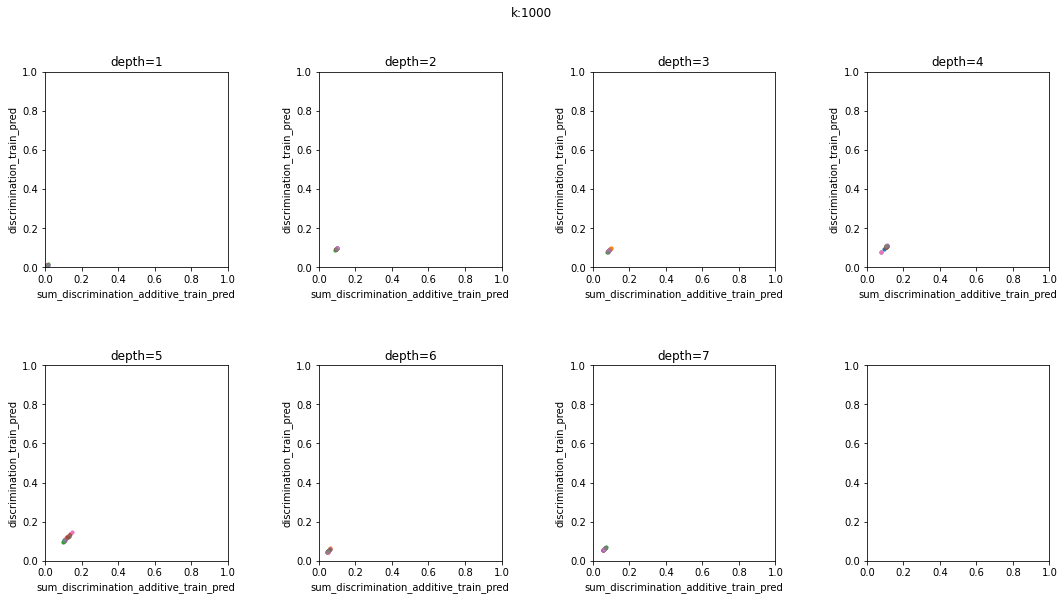

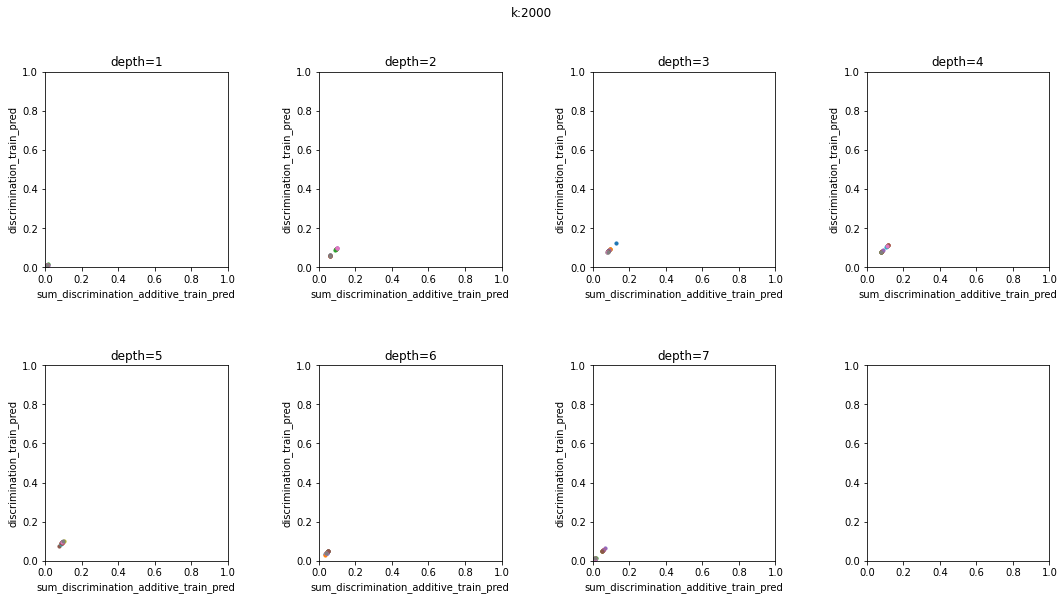

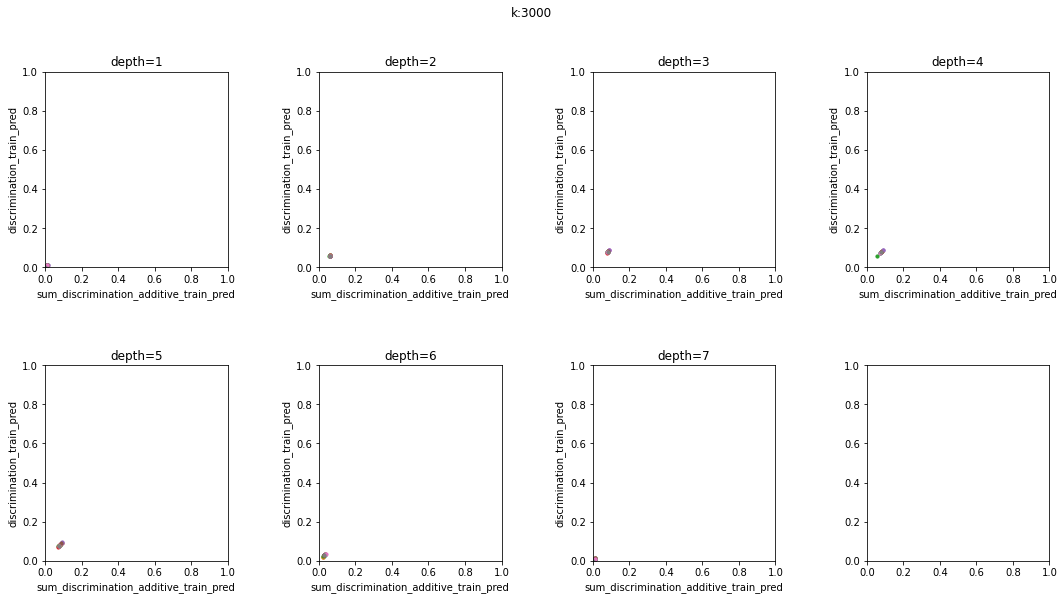

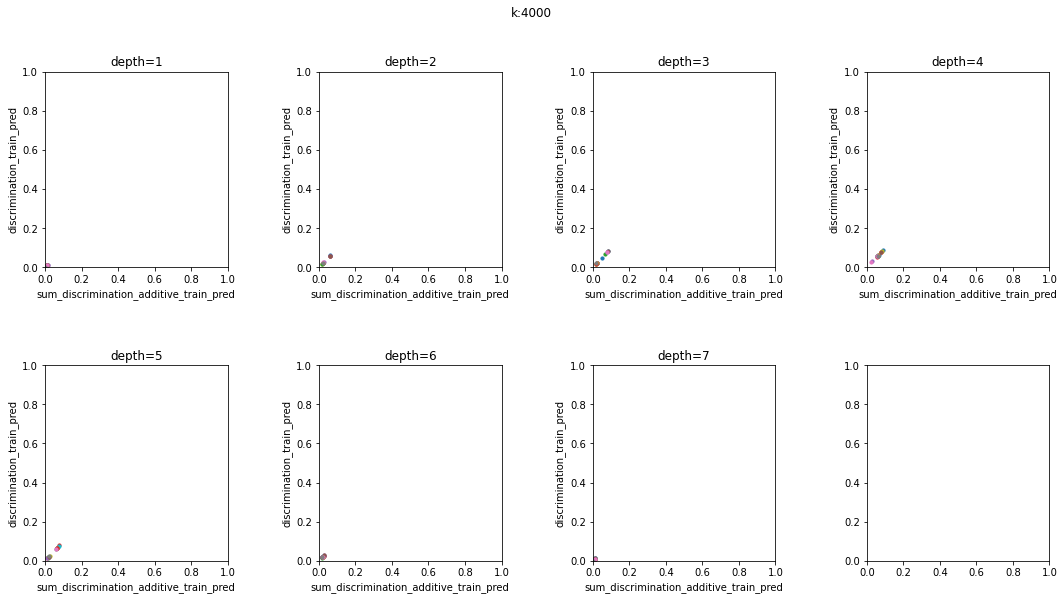

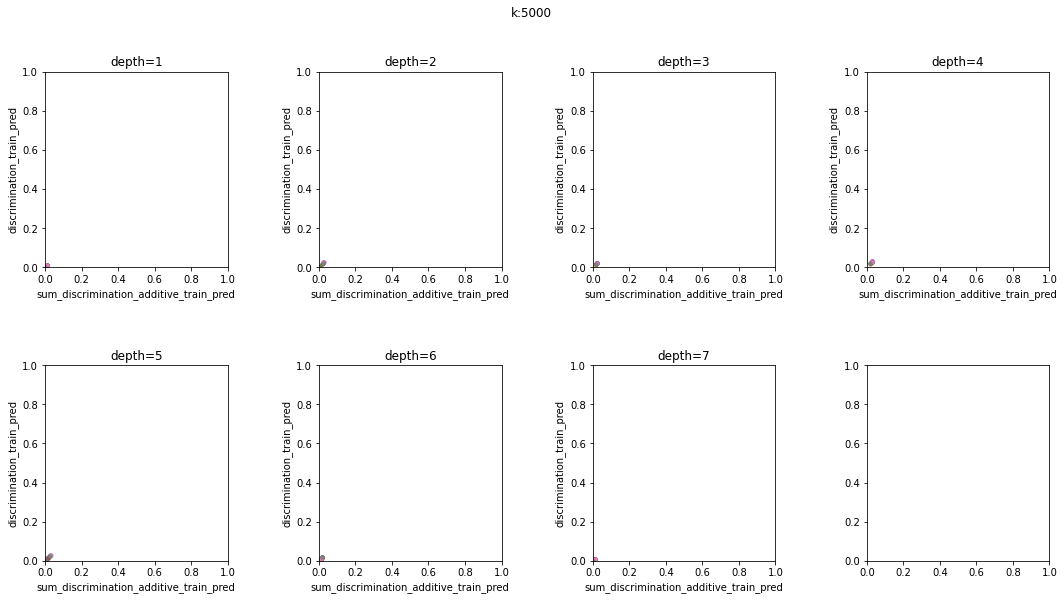

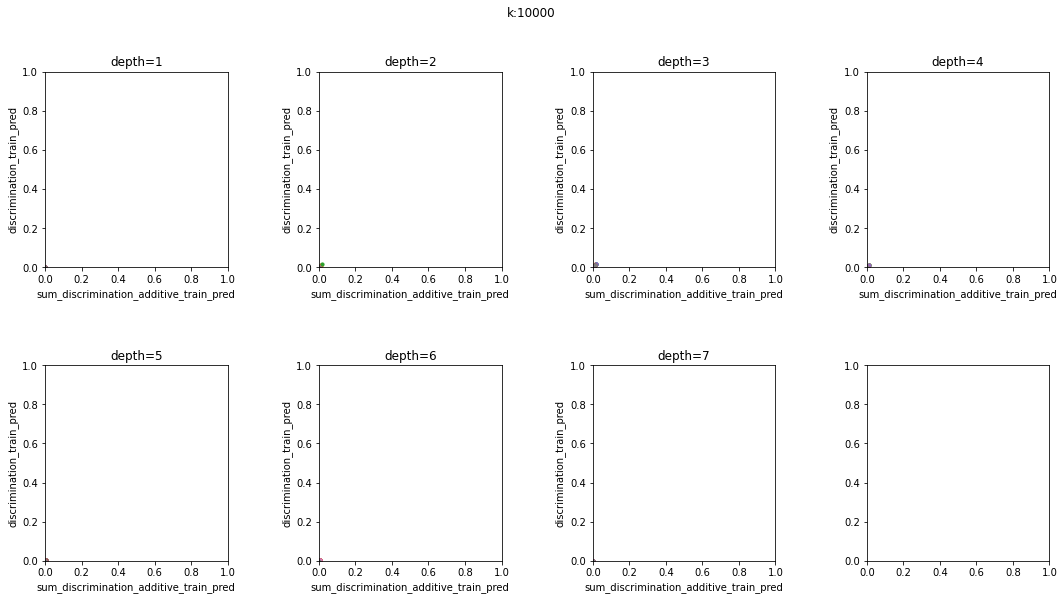

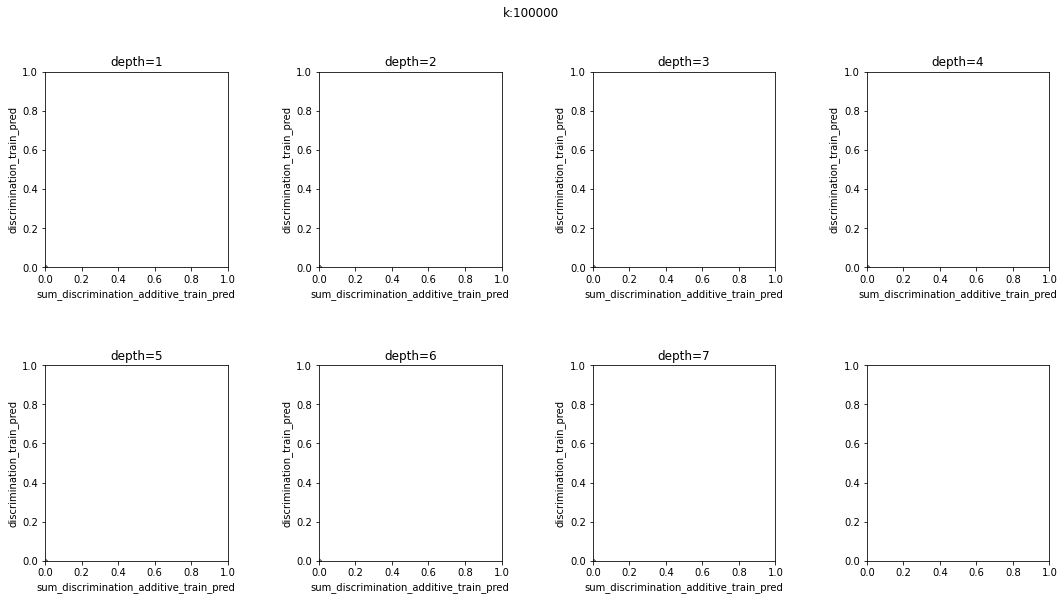

In [25]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, (0, 1), (0, 1))

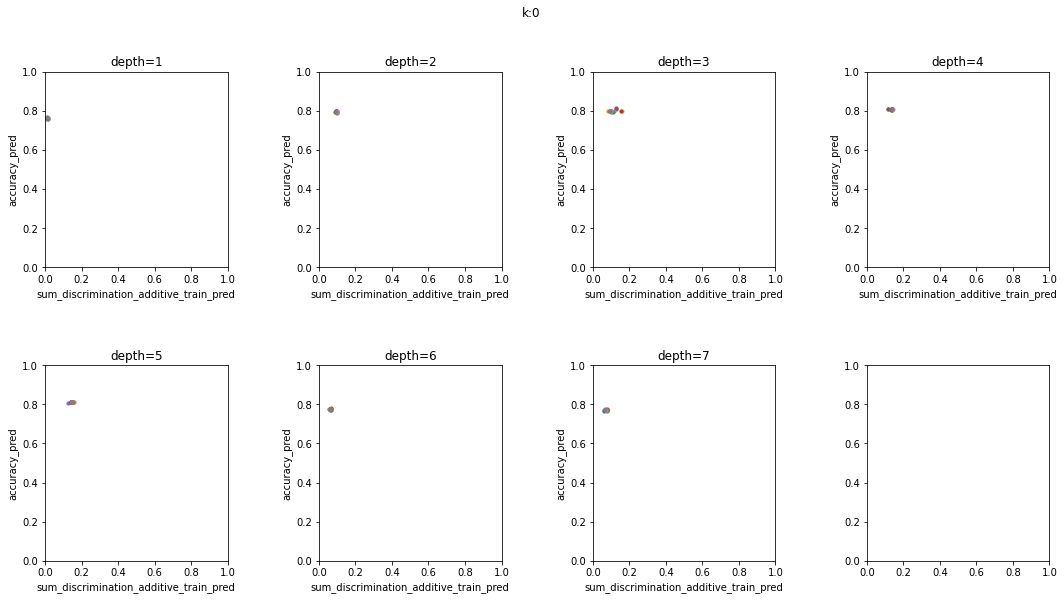

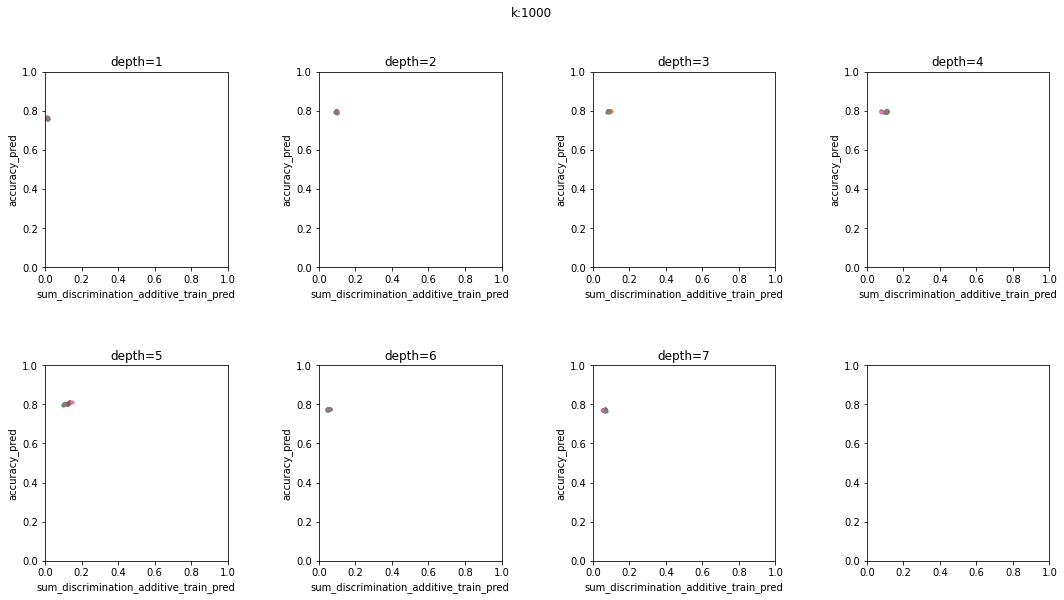

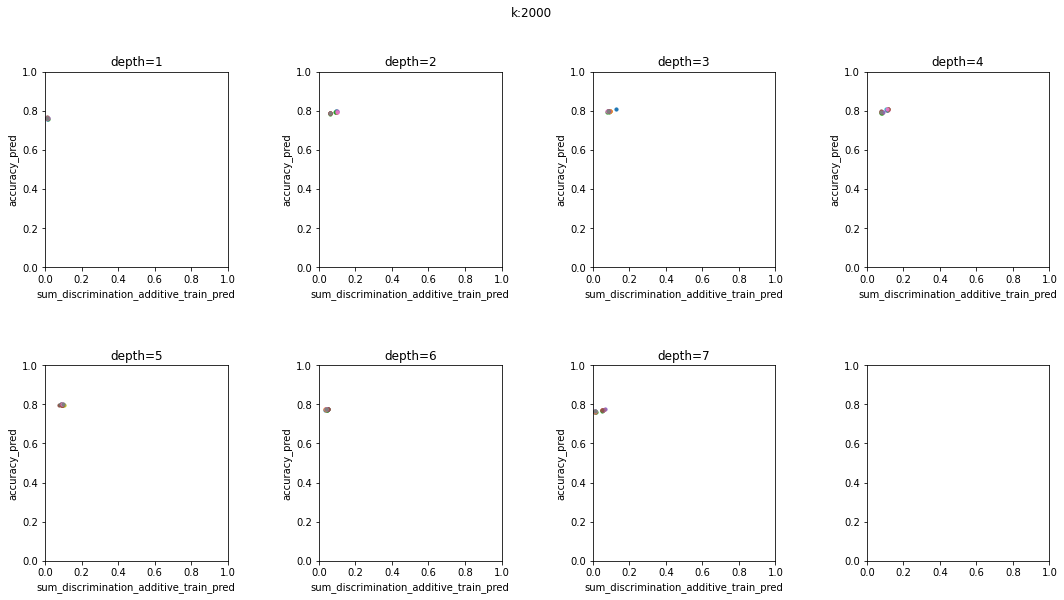

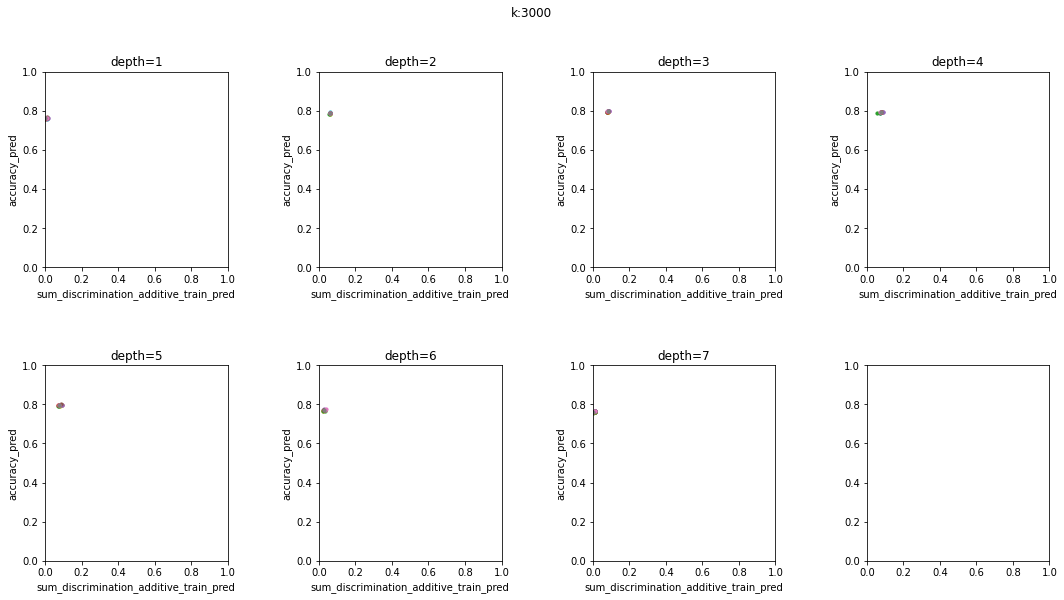

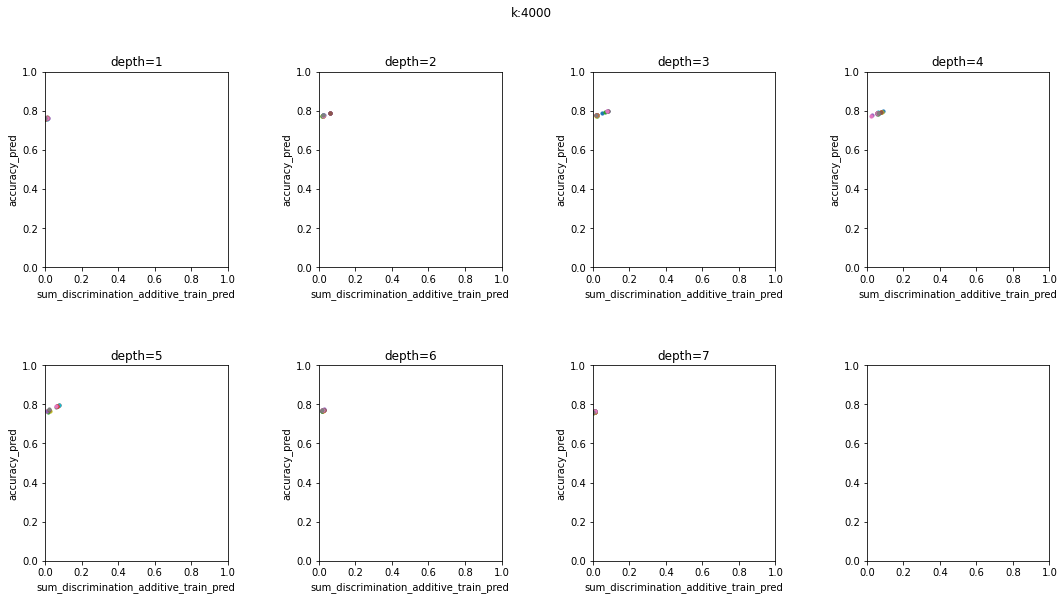

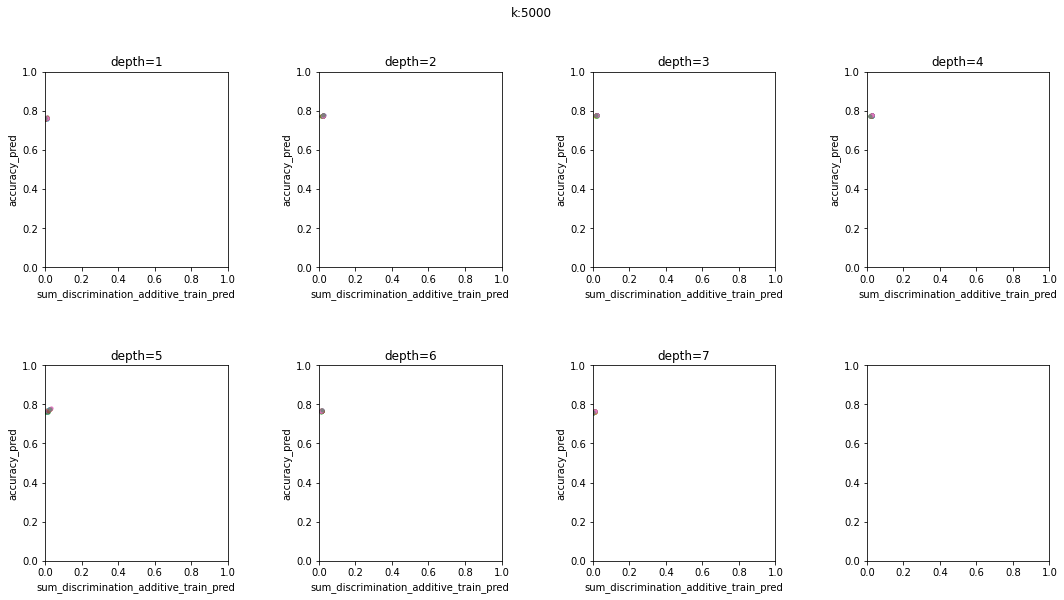

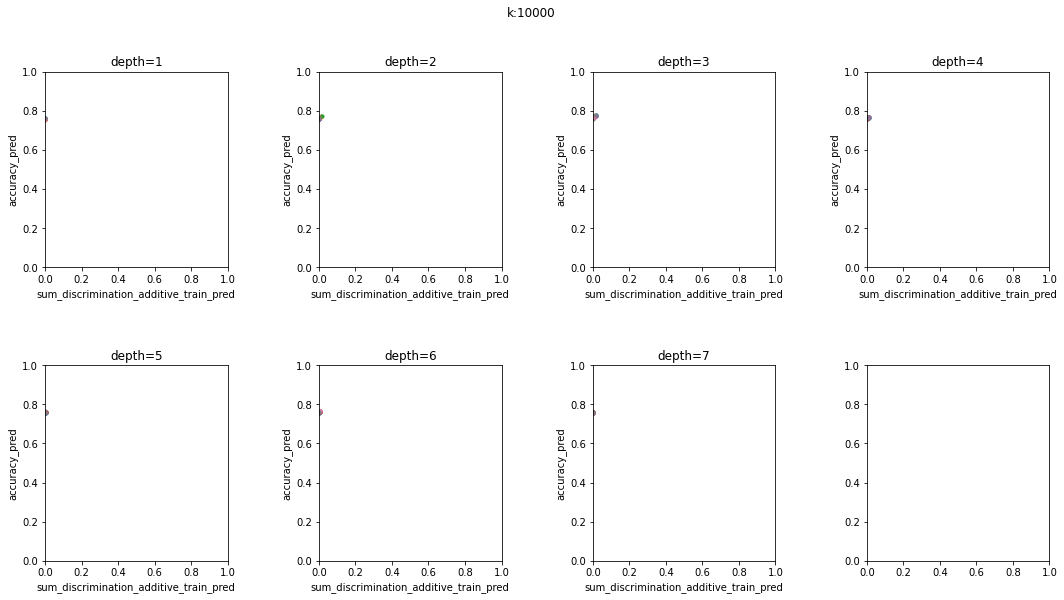

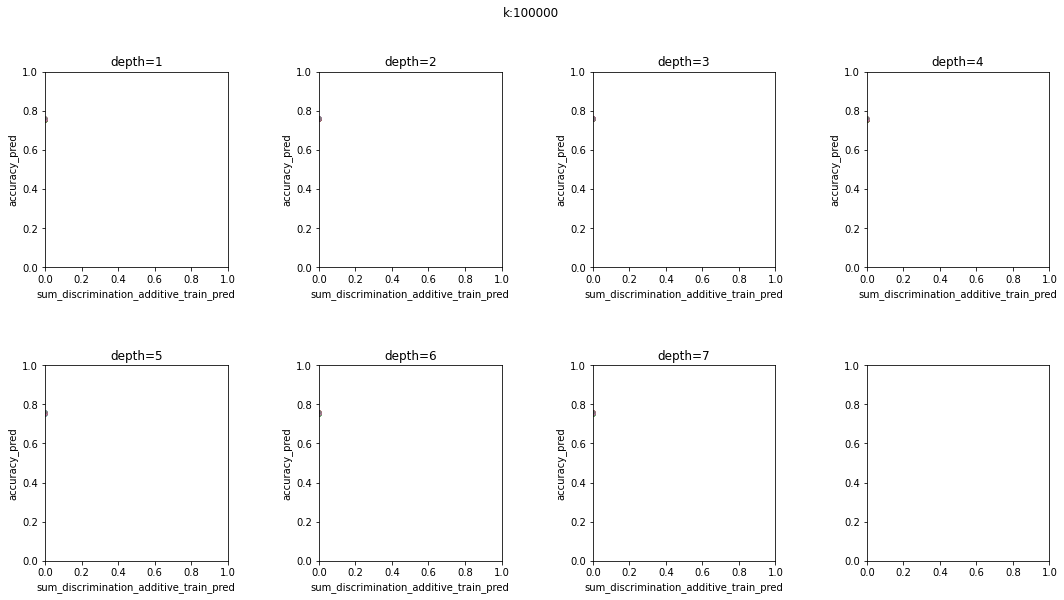

In [26]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "accuracy_pred", result, (0, 1), (0, 1))

<Figure size 648x432 with 0 Axes>

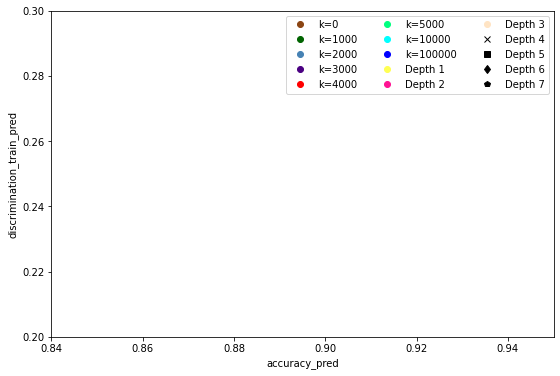

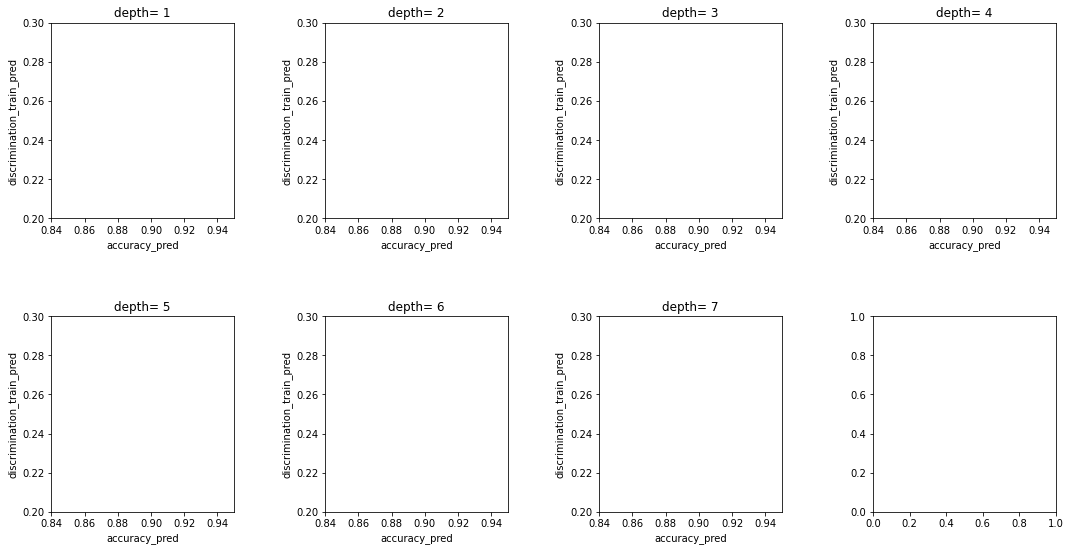

In [27]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

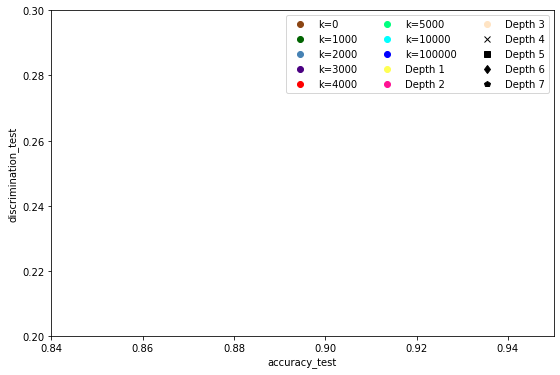

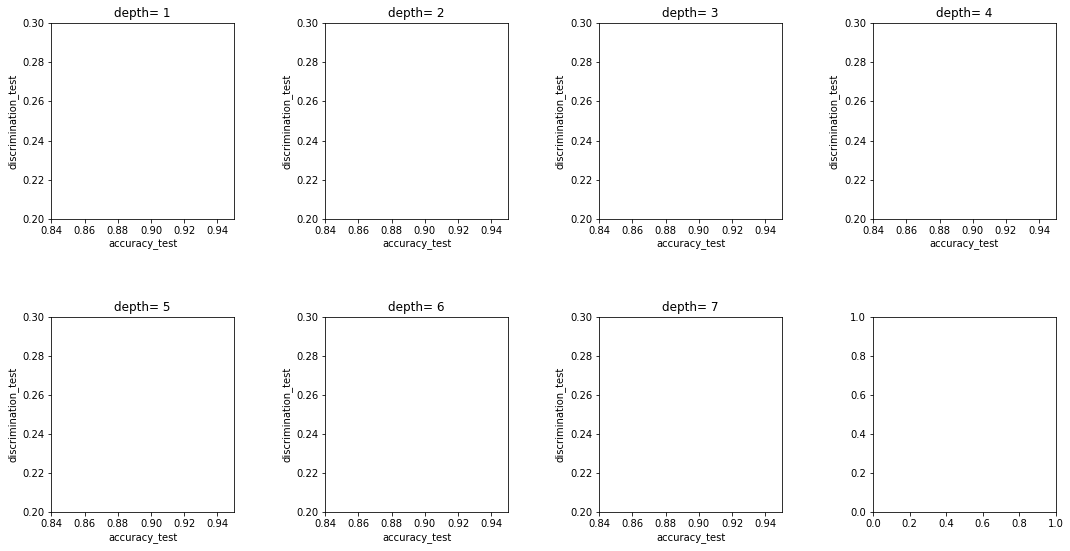

In [28]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

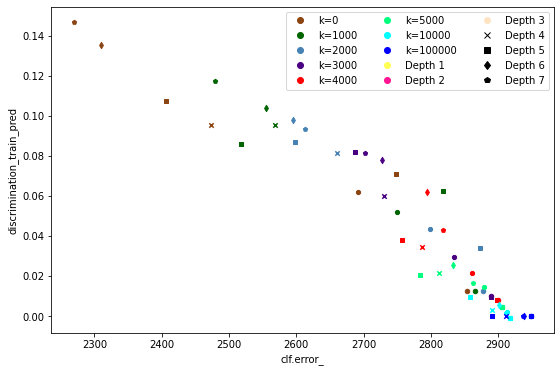

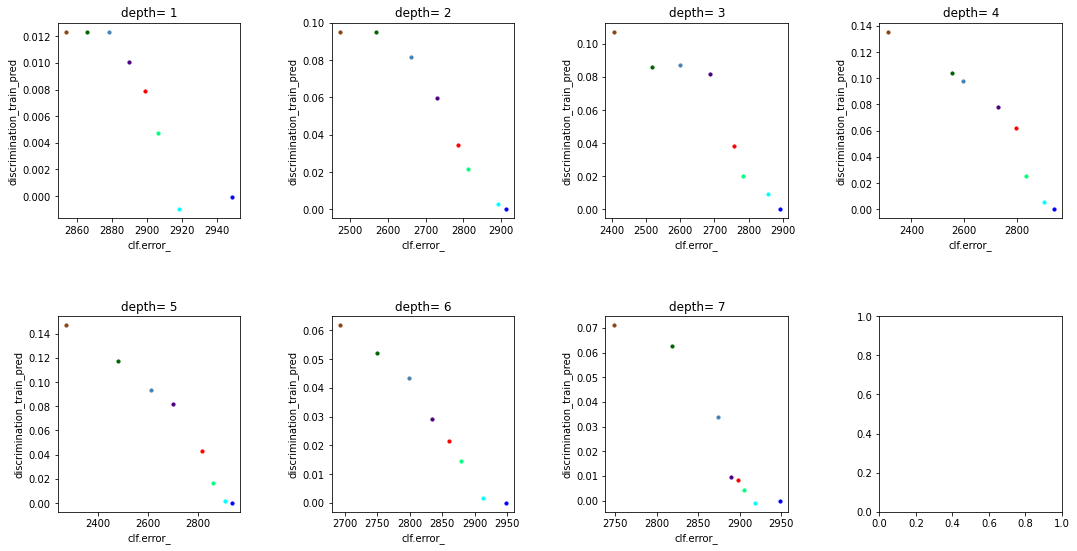

In [29]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

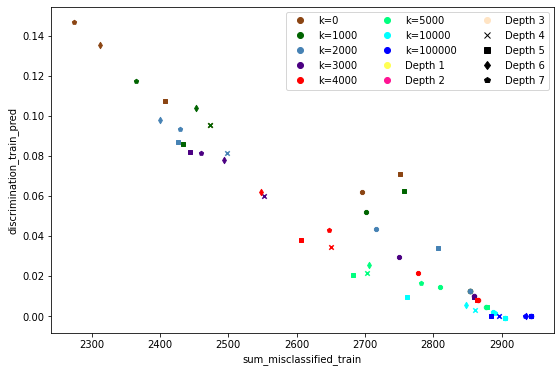

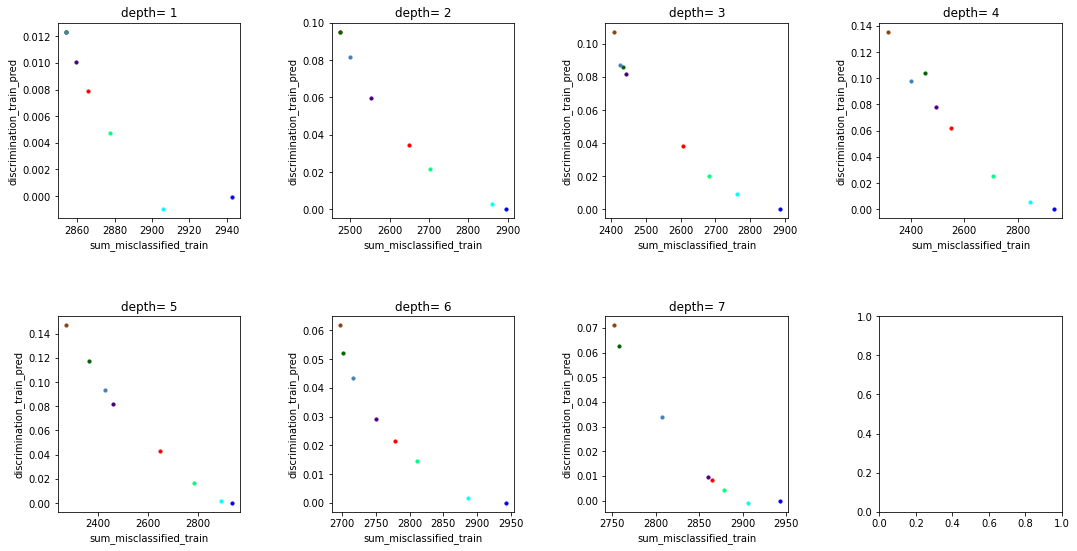

In [30]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

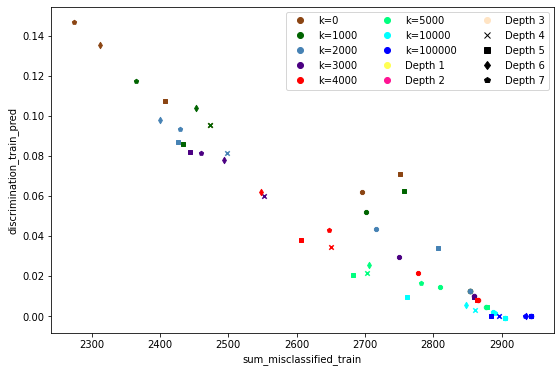

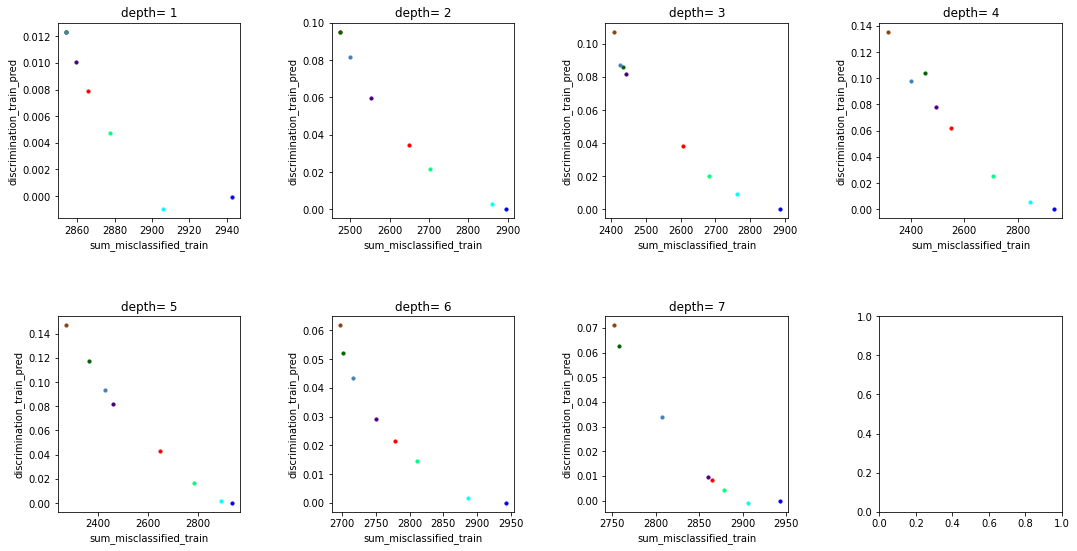

In [31]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

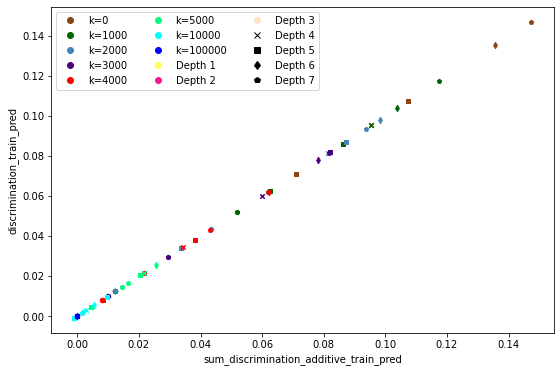

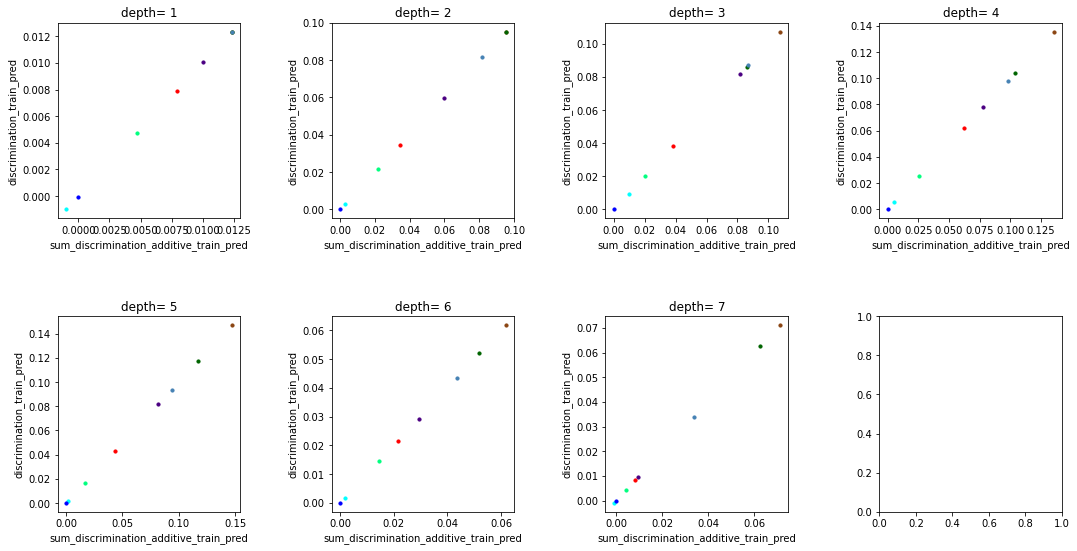

In [32]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

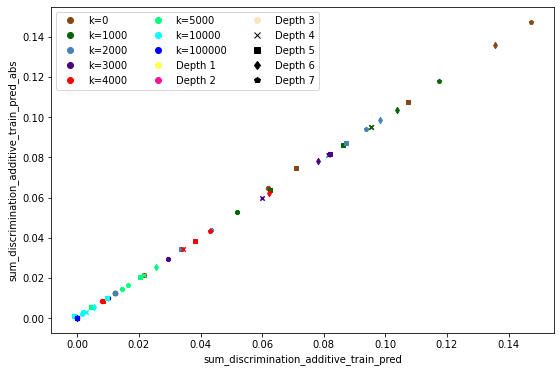

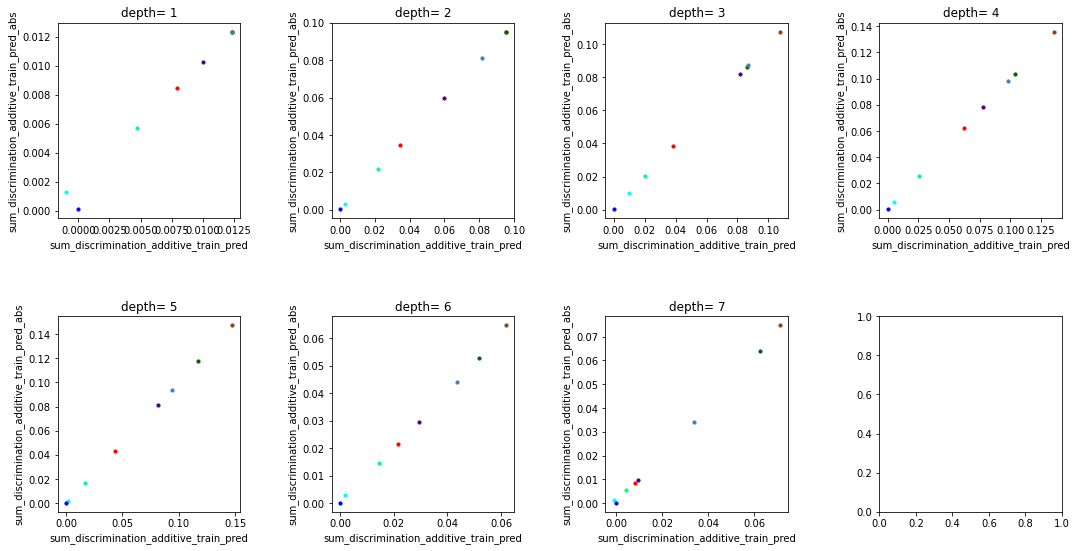

In [33]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)